In [5]:
# %% Cell 1: imports & config

import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make plots a bit nicer
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True

# === PATH TO YOUR CSVs ===
BASE_DIR = Path(r"C:\Users\rog\THESIS\Boot Straps\bootstrap")

# Map datasets -> model variant -> csv file
DATASET_FILES = {
    "DRIVE": {
        "DRIU_VGN":         "DRIU_VGN_DRIVE.csv",
        "DAU2_VGN":         "DAU2_VGN_DRIVE.csv",
        "DRIU_AFF_STATIC":  "DRIU_VGN_AFF_STATIC_DRIVE.csv",
        "DRIU_AFF_DYNAMIC": "DRIU_VGN_AFF_DYNAMIC_DRIVE.csv",
        "DAU2_AFF_DYNAMIC": "DAU2_VGN_AFF_DRIVE.csv",
    },
    "CHASE": {
        "DRIU_VGN":         "DRIU_VGN_CHASE.csv",
        "DAU2_VGN":         "DAU2_VGN_CHASE.csv",
        "DRIU_AFF_STATIC":  "DRIU_VGN_AFF_STATIC_CHASE.csv",
        "DRIU_AFF_DYNAMIC": "DRIU_VGN_AFF_DYNAMIC_CHASE.csv",
        "DAU2_AFF_DYNAMIC": "DAU2_VGN_AFF_CHASE.csv",
    },
    "HRF": {
        "DRIU_VGN":         "DRIU_VGN_HRF.csv",
        "DAU2_VGN":         "DAU2_VGN_HRF.csv",
        "DRIU_AFF_STATIC":  "DRIU_VGN_AFF_STATIC_HRF.csv",
        "DRIU_AFF_DYNAMIC": "DRIU_VGN_AFF_DYNAMIC_HRF.csv",
        "DAU2_AFF_DYNAMIC": "DAU2_VGN_AFF_HRF.csv",
    },
}

METRICS = ["accuracy", "specificity", "sensitivity", "precision", "dice", "iou"]


In [6]:
# %% Cell 2: load data

def load_all_data(base_dir: Path, dataset_files: dict) -> dict:
    """
    Returns:
        data[dataset][model] -> DataFrame with columns:
        ['image_id', 'accuracy', 'specificity', 'sensitivity', 'precision', 'dice', 'iou']
    """
    data = {}
    for dataset, models in dataset_files.items():
        data[dataset] = {}
        for model_key, csv_name in models.items():
            csv_path = base_dir / csv_name
            if not csv_path.exists():
                raise FileNotFoundError(f"Missing csv: {csv_path}")
            df = pd.read_csv(csv_path)
            # make sure image_id is string so merge is safe
            if "image_id" not in df.columns:
                raise ValueError(f"'image_id' column missing in {csv_path}")
            df["image_id"] = df["image_id"].astype(str)
            data[dataset][model_key] = df
    return data

data = load_all_data(BASE_DIR, DATASET_FILES)

for ds, models in data.items():
    print(f"{ds}:")
    for m, df in models.items():
        print(f"  {m:17s}  n={len(df)}")


DRIVE:
  DRIU_VGN           n=20
  DAU2_VGN           n=20
  DRIU_AFF_STATIC    n=20
  DRIU_AFF_DYNAMIC   n=20
  DAU2_AFF_DYNAMIC   n=20
CHASE:
  DRIU_VGN           n=8
  DAU2_VGN           n=8
  DRIU_AFF_STATIC    n=8
  DRIU_AFF_DYNAMIC   n=8
  DAU2_AFF_DYNAMIC   n=8
HRF:
  DRIU_VGN           n=30
  DAU2_VGN           n=30
  DRIU_AFF_STATIC    n=30
  DRIU_AFF_DYNAMIC   n=30
  DAU2_AFF_DYNAMIC   n=30


In [7]:
# %% Cell 3: bootstrap helpers

def bootstrap_mean_diff(diffs, n_boot=10000, ci=0.95, seed=1337):
    """
    diffs: 1D array of paired differences (model_B - model_A) per image
    """
    diffs = np.asarray(diffs, dtype=float)
    n = diffs.size
    if n == 0:
        raise ValueError("No samples for bootstrap.")
        
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, n, size=(n_boot, n))
    boot_means = diffs[idx].mean(axis=1)

    alpha = 1 - ci
    ci_low, ci_high = np.percentile(boot_means, [100*alpha/2, 100*(1 - alpha/2)])

    # crude two‑sided p ≈ probability of being on wrong side of zero
    p_two_sided = 2 * min(
        (boot_means <= 0).mean(),
        (boot_means >= 0).mean(),
    )

    return {
        "n": int(n),
        "mean_diff": float(diffs.mean()),
        "ci_low": float(ci_low),
        "ci_high": float(ci_high),
        "p_boot": float(p_two_sided),
        "significant": bool(ci_low > 0 or ci_high < 0),
    }


def run_bootstrap_for_pair(
    data: dict,
    dataset: str,
    model_a: str,
    model_b: str,
    metrics,
    exp_name: str,
    n_boot=10000,
    seed=1337,
):
    """
    Returns a list of dict rows with bootstrap results for one dataset + model pair.
    """
    df_a = data[dataset][model_a]
    df_b = data[dataset][model_b]

    merged = pd.merge(
        df_a[["image_id"] + list(metrics)],
        df_b[["image_id"] + list(metrics)],
        on="image_id",
        suffixes=("_A", "_B"),
        validate="one_to_one",
    )

    rows = []
    for metric in metrics:
        diffs = merged[f"{metric}_B"].values - merged[f"{metric}_A"].values
        stats = bootstrap_mean_diff(diffs, n_boot=n_boot, seed=seed)
        rows.append(
            {
                "experiment": exp_name,
                "dataset": dataset,
                "metric": metric,
                "model_A": model_a,
                "model_B": model_b,
                **stats,
            }
        )
    return rows


In [23]:
# %% Cell 4: run bootstrap for all experiments

N_BOOT = 10000  # to avoid monte carlos error. we use 10k resamples

results = []

# --- Experiment 1: Backbone replacement (DRIU_VGN -> DAU2_VGN) ---
exp1_pairs = {ds: ("DRIU_VGN", "DAU2_VGN") for ds in DATASET_FILES.keys()}
for ds, (ma, mb) in exp1_pairs.items():
    results.extend(
        run_bootstrap_for_pair(
            data, ds, ma, mb, METRICS,
            exp_name=f"{ma} VS {mb}(BACKBONE)",  # More descriptive experiment name
            n_boot=N_BOOT,
        )
    )

# --- Experiment 2: Fusion strategy (simple stack -> AFF with dynamic µ) ---
# Only Dice & IoU for this hypothesis
exp2_metrics = ["dice", "iou"]
exp2_pairs = {ds: ("DRIU_VGN", "DRIU_AFF_DYNAMIC") for ds in DATASET_FILES.keys()}
for ds, (ma, mb) in exp2_pairs.items():
    results.extend(
        run_bootstrap_for_pair(
            data, ds, ma, mb, exp2_metrics,
            exp_name=f"{ma} VS {mb}(AFF_VS_STACK)",  # More descriptive experiment name
            n_boot=N_BOOT,
        )
    )

# --- Experiment 3: Dynamic vs Static µ inside AFF ---
exp3_pairs = {ds: ("DRIU_AFF_STATIC", "DRIU_AFF_DYNAMIC") for ds in DATASET_FILES.keys()}
for ds, (ma, mb) in exp3_pairs.items():
    results.extend(
        run_bootstrap_for_pair(
            data, ds, ma, mb, METRICS,
            exp_name=f"{ma} VS {mb}(DYNAMIC_VS_STATIC)",  # More descriptive experiment name
            n_boot=N_BOOT,
        )
    )

# --- Experiment 4: Full model (baseline DRIU_VGN -> DAU2_AFF_DYNAMIC) ---
exp4_pairs = {ds: ("DRIU_VGN", "DAU2_AFF_DYNAMIC") for ds in DATASET_FILES.keys()}
for ds, (ma, mb) in exp4_pairs.items():
    results.extend(
        run_bootstrap_for_pair(
            data, ds, ma, mb, METRICS,
            exp_name=f"{ma} VS {mb}(FULL_MODEL)",  # More descriptive experiment name
            n_boot=N_BOOT,
        )
    )

boot_df = pd.DataFrame(results)
boot_df

,experiment,dataset,metric,model_A,model_B,n,mean_diff,ci_low,ci_high,p_boot,significant
0,DRIU_VGN VS DAU2_VGN(BACKBONE),DRIVE,accuracy,DRIU_VGN,DAU2_VGN,20,-0.010456,-0.012804,-0.008092,0.0000,True
1,DRIU_VGN VS DAU2_VGN(BACKBONE),DRIVE,specificity,DRIU_VGN,DAU2_VGN,20,-0.010431,-0.013217,-0.007608,0.0000,True
2,DRIU_VGN VS DAU2_VGN(BACKBONE),DRIVE,sensitivity,DRIU_VGN,DAU2_VGN,20,-0.010384,-0.012395,-0.008363,0.0000,True
3,DRIU_VGN VS DAU2_VGN(BACKBONE),DRIVE,precision,DRIU_VGN,DAU2_VGN,20,-0.033175,-0.041373,-0.025106,0.0000,True
4,DRIU_VGN VS DAU2_VGN(BACKBONE),DRIVE,dice,DRIU_VGN,DAU2_VGN,20,-0.027116,-0.032989,-0.021483,0.0000,True
5,DRIU_VGN VS DAU2_VGN(BACKBONE),DRIVE,iou,DRIU_VGN,DAU2_VGN,20,-0.034782,-0.042011,-0.027721,0.0000,True
6,DRIU_VGN VS DAU2_VGN(BACKBONE),CHASE,accuracy,DRIU_VGN,DAU2_VGN,8,0.006437,0.004766,0.008104,0.0000,True
7,DRIU_VGN VS DAU2_VGN(BACKBONE),CHASE,specificity,DRIU_VGN,DAU2_VGN,8,0.006843,0.004906,0.008723,0.0000,True
8,DRIU_VGN VS DAU2_VGN(BACKBONE),CHASE,sensitivity,DRIU_VGN,DAU2_VGN,8,0.002396,-0.003777,0.009002,0.4968,False
9,DRIU_VGN VS DAU2_VGN(BACKBONE),CHASE,precision,DRIU_VGN,DAU2_VGN,8,0.027464,0.019860,0.035593,0.0000,True


In [10]:
# %% Cell 5: summary tables per experiment

def nice_summary(df, exp_name, decimals=4):
    sub = df[df["experiment"] == exp_name].copy()
    sub = sub.sort_values(["metric", "dataset"])
    cols = ["dataset", "metric", "model_A", "model_B",
            "n", "mean_diff", "ci_low", "ci_high", "p_boot", "significant"]
    disp = sub[cols].copy()
    for c in ["mean_diff", "ci_low", "ci_high", "p_boot"]:
        disp[c] = disp[c].round(decimals)
    print(f"\n===== {exp_name} =====")
    display(disp)


for exp in boot_df["experiment"].unique():
    nice_summary(boot_df, exp)



===== Exp1_Backbone =====


,dataset,metric,model_A,model_B,n,mean_diff,ci_low,ci_high,p_boot,significant
6,CHASE,accuracy,DRIU_VGN,DAU2_VGN,8,0.0064,0.0048,0.0081,0.0000,True
0,DRIVE,accuracy,DRIU_VGN,DAU2_VGN,20,-0.0105,-0.0128,-0.0081,0.0000,True
12,HRF,accuracy,DRIU_VGN,DAU2_VGN,30,0.0197,0.0161,0.0233,0.0000,True
10,CHASE,dice,DRIU_VGN,DAU2_VGN,8,0.0210,0.0154,0.0270,0.0000,True
4,DRIVE,dice,DRIU_VGN,DAU2_VGN,20,-0.0271,-0.0330,-0.0215,0.0000,True
16,HRF,dice,DRIU_VGN,DAU2_VGN,30,0.0056,-0.0097,0.0212,0.4772,False
11,CHASE,iou,DRIU_VGN,DAU2_VGN,8,0.0266,0.0196,0.0341,0.0000,True
5,DRIVE,iou,DRIU_VGN,DAU2_VGN,20,-0.0348,-0.0420,-0.0277,0.0000,True
17,HRF,iou,DRIU_VGN,DAU2_VGN,30,0.0066,-0.0126,0.0261,0.5038,False
9,CHASE,precision,DRIU_VGN,DAU2_VGN,8,0.0275,0.0199,0.0356,0.0000,True



===== Exp2_AFF_vs_Stack =====


,dataset,metric,model_A,model_B,n,mean_diff,ci_low,ci_high,p_boot,significant
20,CHASE,dice,DRIU_VGN,DRIU_AFF_DYNAMIC,8,0.0426,0.0351,0.0512,0.0,True
18,DRIVE,dice,DRIU_VGN,DRIU_AFF_DYNAMIC,20,0.0453,0.0376,0.0533,0.0,True
22,HRF,dice,DRIU_VGN,DRIU_AFF_DYNAMIC,30,-0.0684,-0.0761,-0.0604,0.0,True
21,CHASE,iou,DRIU_VGN,DRIU_AFF_DYNAMIC,8,0.0547,0.0457,0.0653,0.0,True
19,DRIVE,iou,DRIU_VGN,DRIU_AFF_DYNAMIC,20,0.0614,0.0514,0.0716,0.0,True
23,HRF,iou,DRIU_VGN,DRIU_AFF_DYNAMIC,30,0.3023,0.2888,0.3158,0.0,True



===== Exp3_Dynamic_vs_Static_mu =====


,dataset,metric,model_A,model_B,n,mean_diff,ci_low,ci_high,p_boot,significant
30,CHASE,accuracy,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,8,0.0013,0.0010,0.0015,0.0,True
24,DRIVE,accuracy,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,20,0.0109,0.0094,0.0125,0.0,True
36,HRF,accuracy,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,30,0.0038,0.0033,0.0042,0.0,True
34,CHASE,dice,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,8,0.0040,0.0030,0.0051,0.0,True
28,DRIVE,dice,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,20,0.0214,0.0162,0.0267,0.0,True
40,HRF,dice,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,30,-0.1232,-0.1302,-0.1159,0.0,True
35,CHASE,iou,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,8,0.0054,0.0041,0.0068,0.0,True
29,DRIVE,iou,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,20,0.0296,0.0224,0.0367,0.0,True
41,HRF,iou,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,30,0.2314,0.2195,0.2431,0.0,True
33,CHASE,precision,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,8,0.0081,0.0071,0.0093,0.0,True



===== Exp4_Full_Model =====


,dataset,metric,model_A,model_B,n,mean_diff,ci_low,ci_high,p_boot,significant
48,CHASE,accuracy,DRIU_VGN,DAU2_AFF_DYNAMIC,8,0.0269,0.0248,0.0286,0.0000,True
42,DRIVE,accuracy,DRIU_VGN,DAU2_AFF_DYNAMIC,20,0.0138,0.0098,0.0176,0.0000,True
54,HRF,accuracy,DRIU_VGN,DAU2_AFF_DYNAMIC,30,-0.0208,-0.0234,-0.0179,0.0000,True
52,CHASE,dice,DRIU_VGN,DAU2_AFF_DYNAMIC,8,0.0803,0.0719,0.0891,0.0000,True
46,DRIVE,dice,DRIU_VGN,DAU2_AFF_DYNAMIC,20,0.0075,-0.0024,0.0180,0.1386,False
58,HRF,dice,DRIU_VGN,DAU2_AFF_DYNAMIC,30,-0.0741,-0.0799,-0.0682,0.0000,True
53,CHASE,iou,DRIU_VGN,DAU2_AFF_DYNAMIC,8,0.1068,0.0967,0.1177,0.0000,True
47,DRIVE,iou,DRIU_VGN,DAU2_AFF_DYNAMIC,20,0.0098,-0.0029,0.0233,0.1324,False
59,HRF,iou,DRIU_VGN,DAU2_AFF_DYNAMIC,30,-0.0875,-0.0961,-0.0794,0.0000,True
51,CHASE,precision,DRIU_VGN,DAU2_AFF_DYNAMIC,8,0.1758,0.1685,0.1840,0.0000,True


In [11]:
# %% Cell 5: summary tables per experiment

def nice_summary(df, exp_name, decimals=4):
    sub = df[df["experiment"] == exp_name].copy()
    sub = sub.sort_values(["metric", "dataset"])
    cols = ["dataset", "metric", "model_A", "model_B",
            "n", "mean_diff", "ci_low", "ci_high", "p_boot", "significant"]
    disp = sub[cols].copy()
    for c in ["mean_diff", "ci_low", "ci_high", "p_boot"]:
        disp[c] = disp[c].round(decimals)
    print(f"\n===== {exp_name} =====")
    display(disp)


for exp in boot_df["experiment"].unique():
    nice_summary(boot_df, exp)



===== Exp1_Backbone =====


,dataset,metric,model_A,model_B,n,mean_diff,ci_low,ci_high,p_boot,significant
6,CHASE,accuracy,DRIU_VGN,DAU2_VGN,8,0.0064,0.0048,0.0081,0.0000,True
0,DRIVE,accuracy,DRIU_VGN,DAU2_VGN,20,-0.0105,-0.0128,-0.0081,0.0000,True
12,HRF,accuracy,DRIU_VGN,DAU2_VGN,30,0.0197,0.0161,0.0233,0.0000,True
10,CHASE,dice,DRIU_VGN,DAU2_VGN,8,0.0210,0.0154,0.0270,0.0000,True
4,DRIVE,dice,DRIU_VGN,DAU2_VGN,20,-0.0271,-0.0330,-0.0215,0.0000,True
16,HRF,dice,DRIU_VGN,DAU2_VGN,30,0.0056,-0.0097,0.0212,0.4772,False
11,CHASE,iou,DRIU_VGN,DAU2_VGN,8,0.0266,0.0196,0.0341,0.0000,True
5,DRIVE,iou,DRIU_VGN,DAU2_VGN,20,-0.0348,-0.0420,-0.0277,0.0000,True
17,HRF,iou,DRIU_VGN,DAU2_VGN,30,0.0066,-0.0126,0.0261,0.5038,False
9,CHASE,precision,DRIU_VGN,DAU2_VGN,8,0.0275,0.0199,0.0356,0.0000,True



===== Exp2_AFF_vs_Stack =====


,dataset,metric,model_A,model_B,n,mean_diff,ci_low,ci_high,p_boot,significant
20,CHASE,dice,DRIU_VGN,DRIU_AFF_DYNAMIC,8,0.0426,0.0351,0.0512,0.0,True
18,DRIVE,dice,DRIU_VGN,DRIU_AFF_DYNAMIC,20,0.0453,0.0376,0.0533,0.0,True
22,HRF,dice,DRIU_VGN,DRIU_AFF_DYNAMIC,30,-0.0684,-0.0761,-0.0604,0.0,True
21,CHASE,iou,DRIU_VGN,DRIU_AFF_DYNAMIC,8,0.0547,0.0457,0.0653,0.0,True
19,DRIVE,iou,DRIU_VGN,DRIU_AFF_DYNAMIC,20,0.0614,0.0514,0.0716,0.0,True
23,HRF,iou,DRIU_VGN,DRIU_AFF_DYNAMIC,30,0.3023,0.2888,0.3158,0.0,True



===== Exp3_Dynamic_vs_Static_mu =====


,dataset,metric,model_A,model_B,n,mean_diff,ci_low,ci_high,p_boot,significant
30,CHASE,accuracy,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,8,0.0013,0.0010,0.0015,0.0,True
24,DRIVE,accuracy,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,20,0.0109,0.0094,0.0125,0.0,True
36,HRF,accuracy,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,30,0.0038,0.0033,0.0042,0.0,True
34,CHASE,dice,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,8,0.0040,0.0030,0.0051,0.0,True
28,DRIVE,dice,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,20,0.0214,0.0162,0.0267,0.0,True
40,HRF,dice,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,30,-0.1232,-0.1302,-0.1159,0.0,True
35,CHASE,iou,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,8,0.0054,0.0041,0.0068,0.0,True
29,DRIVE,iou,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,20,0.0296,0.0224,0.0367,0.0,True
41,HRF,iou,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,30,0.2314,0.2195,0.2431,0.0,True
33,CHASE,precision,DRIU_AFF_STATIC,DRIU_AFF_DYNAMIC,8,0.0081,0.0071,0.0093,0.0,True



===== Exp4_Full_Model =====


,dataset,metric,model_A,model_B,n,mean_diff,ci_low,ci_high,p_boot,significant
48,CHASE,accuracy,DRIU_VGN,DAU2_AFF_DYNAMIC,8,0.0269,0.0248,0.0286,0.0000,True
42,DRIVE,accuracy,DRIU_VGN,DAU2_AFF_DYNAMIC,20,0.0138,0.0098,0.0176,0.0000,True
54,HRF,accuracy,DRIU_VGN,DAU2_AFF_DYNAMIC,30,-0.0208,-0.0234,-0.0179,0.0000,True
52,CHASE,dice,DRIU_VGN,DAU2_AFF_DYNAMIC,8,0.0803,0.0719,0.0891,0.0000,True
46,DRIVE,dice,DRIU_VGN,DAU2_AFF_DYNAMIC,20,0.0075,-0.0024,0.0180,0.1386,False
58,HRF,dice,DRIU_VGN,DAU2_AFF_DYNAMIC,30,-0.0741,-0.0799,-0.0682,0.0000,True
53,CHASE,iou,DRIU_VGN,DAU2_AFF_DYNAMIC,8,0.1068,0.0967,0.1177,0.0000,True
47,DRIVE,iou,DRIU_VGN,DAU2_AFF_DYNAMIC,20,0.0098,-0.0029,0.0233,0.1324,False
59,HRF,iou,DRIU_VGN,DAU2_AFF_DYNAMIC,30,-0.0875,-0.0961,-0.0794,0.0000,True
51,CHASE,precision,DRIU_VGN,DAU2_AFF_DYNAMIC,8,0.1758,0.1685,0.1840,0.0000,True


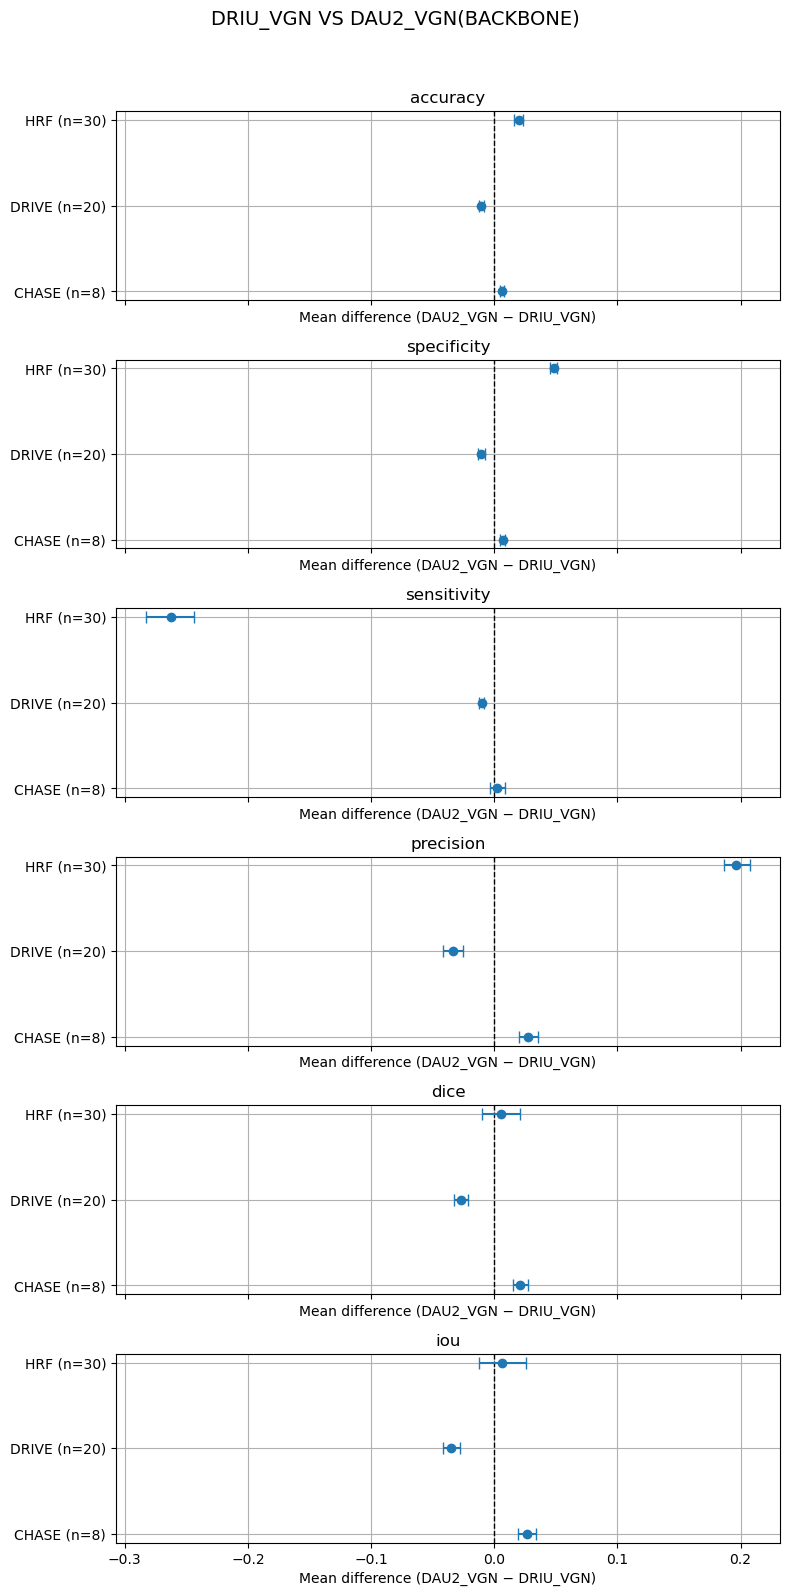

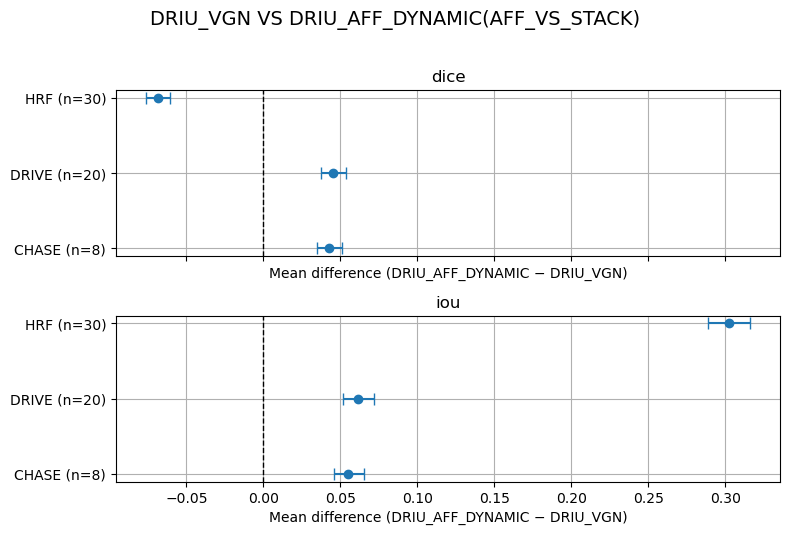

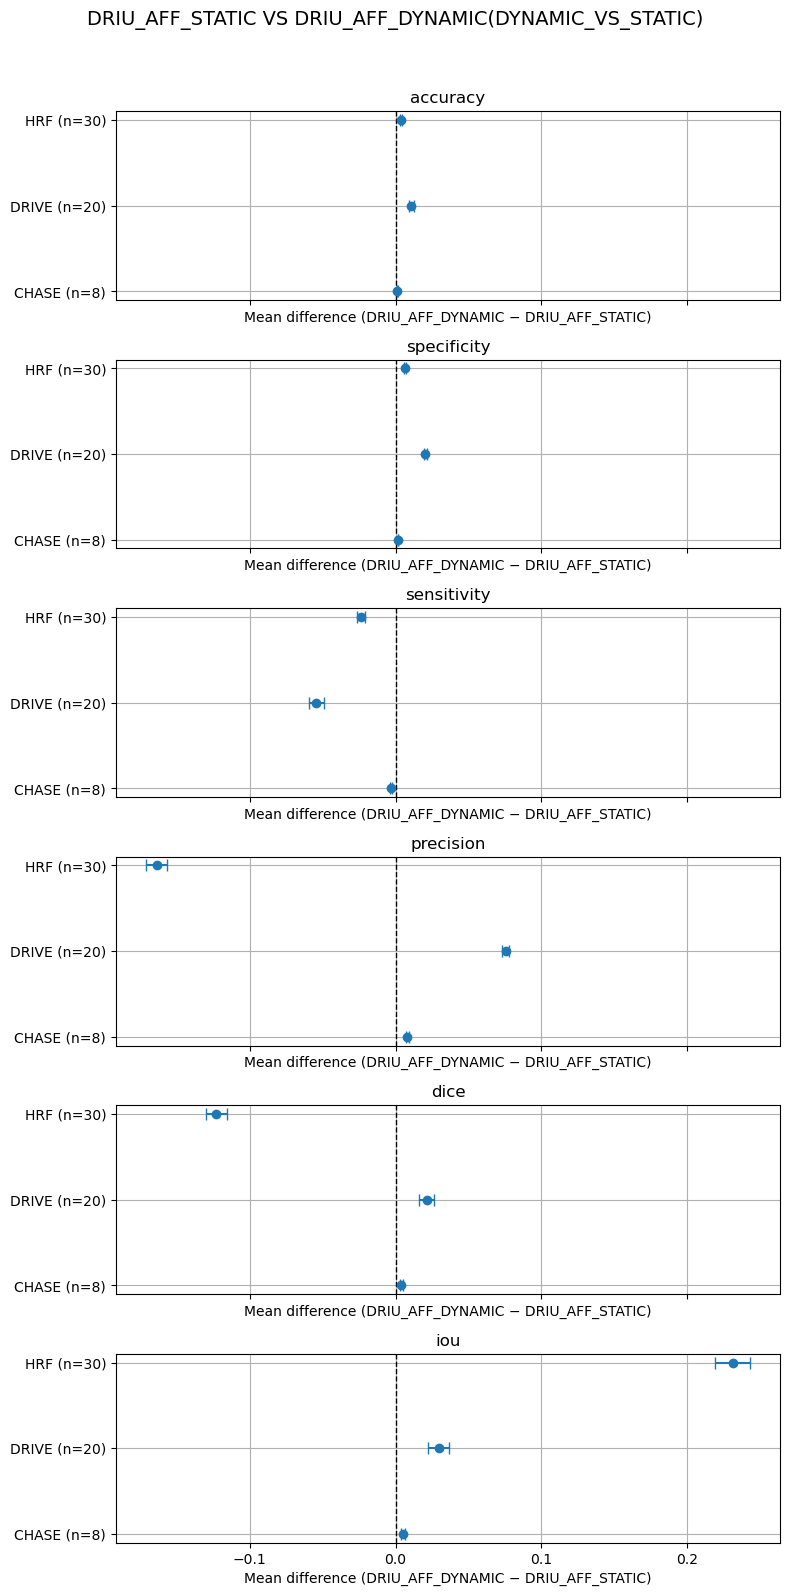

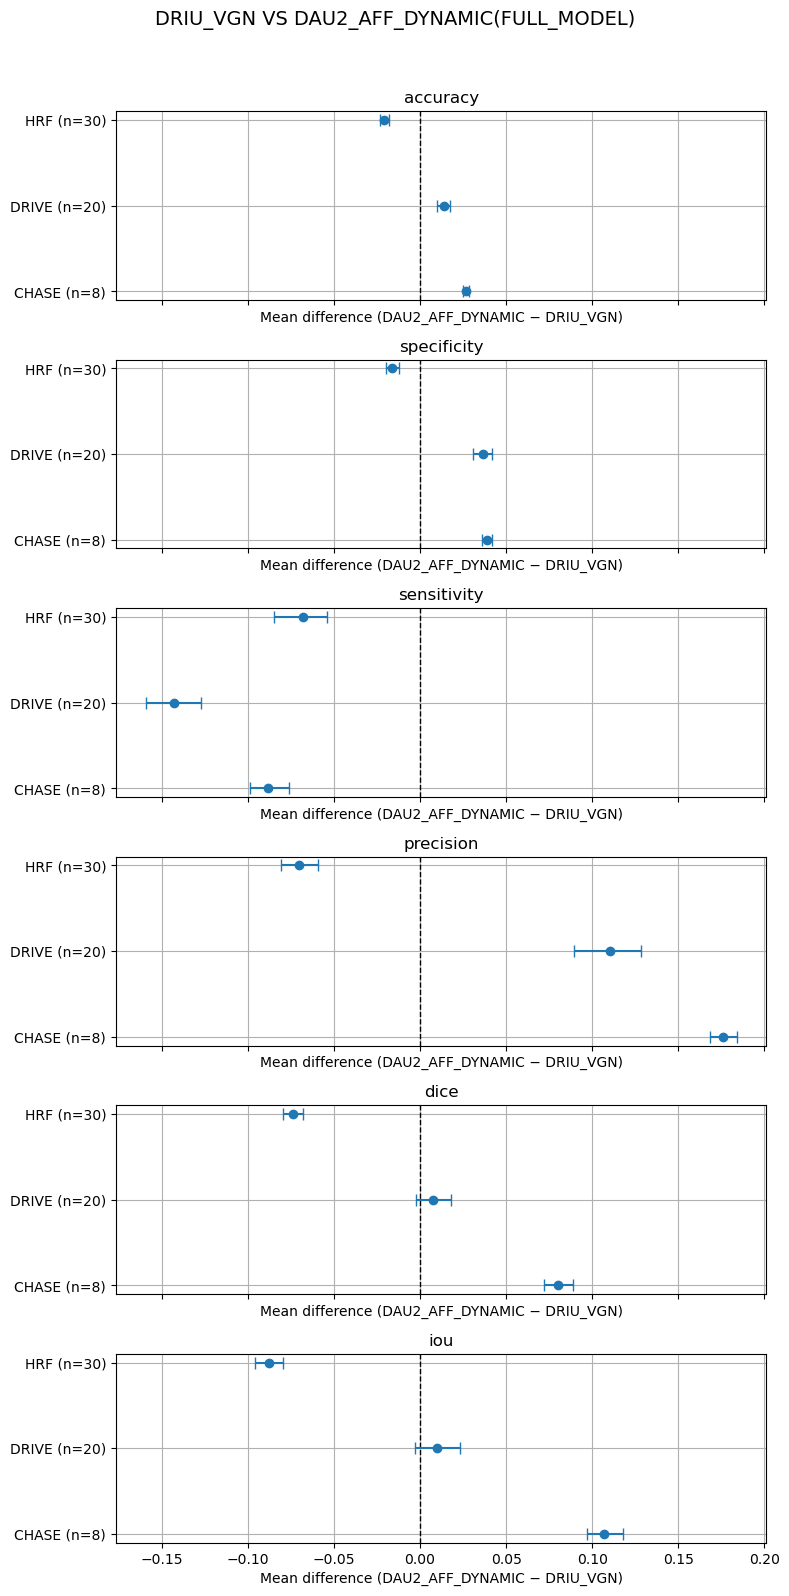

In [24]:
# %% Cell 6: visualisation helpers

def plot_forest_for_experiment(df, exp_name, zero_line=True):
    sub = df[df["experiment"] == exp_name].copy()
    metrics = sub["metric"].unique()
    
    # Extract model names from the experiment name
    # Assuming format is like "MODEL_A VS MODEL_B(DESCRIPTION)"
    model_names = exp_name.split(" VS ")
    if len(model_names) >= 2:
        model_a = model_names[0]
        model_b = model_names[1].split("(")[0]
    else:
        # Fallback to generic names if parsing fails
        model_a = "model_A"
        model_b = "model_B"

    n_rows = len(metrics)
    fig, axes = plt.subplots(n_rows, 1, figsize=(8, 2.6 * n_rows), sharex=True)
    if n_rows == 1:
        axes = [axes]

    for ax, metric in zip(axes, metrics):
        s = sub[sub["metric"] == metric].sort_values("dataset")
        y = np.arange(len(s))

        if zero_line:
            ax.axvline(0.0, color="black", linestyle="--", linewidth=1)

        ax.errorbar(
            s["mean_diff"],
            y,
            xerr=[s["mean_diff"] - s["ci_low"], s["ci_high"] - s["mean_diff"]],
            fmt="o",
            capsize=4,
        )

        labels = [
            f"{d} (n={int(n)})"
            for d, n in zip(s["dataset"], s["n"])
        ]
        ax.set_yticks(y)
        ax.set_yticklabels(labels)
        ax.set_title(f"{metric}")
        # Use actual model names in the x-axis label
        ax.set_xlabel(f"Mean difference ({model_b} − {model_a})")

    fig.suptitle(exp_name, y=1.02, fontsize=14)
    fig.tight_layout()
    plt.show()


for exp in boot_df["experiment"].unique():
    plot_forest_for_experiment(boot_df, exp)

In [26]:
# %% Cell 7: textual verdicts per hypothesis

def print_verdicts(df, exp_name, alpha=0.05):
    sub = df[df["experiment"] == exp_name].copy()
    sub = sub.sort_values(["metric", "dataset"])
    print(f"\n######## {exp_name} ########")
    for row in sub.itertuples():
        direction = "improves" if row.mean_diff > 0 else "worsens"
        if row.ci_low > 0:
            verdict = "SIGNIFICANT improvement (CI > 0)"
        elif row.ci_high < 0:
            verdict = "SIGNIFICANT degradation (CI < 0)"
        else:
            verdict = "NOT statistically significant (CI crosses 0)"
        print(
            f"{row.dataset} – {row.metric}: {row.model_B} {direction} over "
            f"{row.model_A} by {row.mean_diff:.4f} "
            f"[{row.ci_low:.4f}, {row.ci_high:.4f}], p_boot≈{row.p_boot:.4f} → {verdict}"
        )

for exp in boot_df["experiment"].unique():
    print_verdicts(boot_df, exp)



######## DRIU_VGN VS DAU2_VGN(BACKBONE) ########
CHASE – accuracy: DAU2_VGN improves over DRIU_VGN by 0.0064 [0.0048, 0.0081], p_boot≈0.0000 → SIGNIFICANT improvement (CI > 0)
DRIVE – accuracy: DAU2_VGN worsens over DRIU_VGN by -0.0105 [-0.0128, -0.0081], p_boot≈0.0000 → SIGNIFICANT degradation (CI < 0)
HRF – accuracy: DAU2_VGN improves over DRIU_VGN by 0.0197 [0.0161, 0.0233], p_boot≈0.0000 → SIGNIFICANT improvement (CI > 0)
CHASE – dice: DAU2_VGN improves over DRIU_VGN by 0.0210 [0.0154, 0.0270], p_boot≈0.0000 → SIGNIFICANT improvement (CI > 0)
DRIVE – dice: DAU2_VGN worsens over DRIU_VGN by -0.0271 [-0.0330, -0.0215], p_boot≈0.0000 → SIGNIFICANT degradation (CI < 0)
HRF – dice: DAU2_VGN improves over DRIU_VGN by 0.0056 [-0.0097, 0.0212], p_boot≈0.4772 → NOT statistically significant (CI crosses 0)
CHASE – iou: DAU2_VGN improves over DRIU_VGN by 0.0266 [0.0196, 0.0341], p_boot≈0.0000 → SIGNIFICANT improvement (CI > 0)
DRIVE – iou: DAU2_VGN worsens over DRIU_VGN by -0.0348 [-0.0420, 

# Answers

### Experiment 1 – Backbone Replacement (DRIU_VGN → DAU2_VGN)

Hypothesis. Replacing the DRIU backbone with the (DA‑U)²Net backbone (DAU2_VGN) improves vessel segmentation performance across datasets.

The ANOVA and bootstrap results show that the effect of swapping the backbone is not uniformly positive and is clearly dataset‑dependent. On CHASE, DAU2_VGN yields consistent and statistically significant gains over DRIU_VGN on almost all metrics: accuracy, Dice, IoU, precision, and specificity all have positive mean differences with 95% confidence intervals that remain strictly above zero and bootstrap 
𝑝
boot
≈
0
p
boot
	​

≈0. Sensitivity is the only metric where the improvement is small and not statistically reliable (CI crosses zero). In practice this means that, on CHASE, the DAU backbone is genuinely better: it reduces both false positives and false negatives enough to produce better overlap scores.

On DRIVE, the picture flips. DAU2_VGN shows significant degradation in accuracy, Dice, IoU, precision, sensitivity, and specificity; all the CIs are strictly negative and 
𝑝
boot
≈
0
p
boot
	​

≈0. In other words, on DRIVE the DRIU backbone still dominates — DAU2 is systematically worse, not just “within noise”. On HRF, the backbone change again behaves asymmetrically. Accuracy, precision, and specificity all significantly increase under DAU2_VGN, indicating fewer false positives and better background rejection. However, sensitivity collapses hard (mean difference around −0.26 with a very tight CI), meaning a lot of vessels are now being missed. Dice and IoU on HRF improve only slightly or are not statistically significant, which is exactly what you’d expect when you trade recall for precision: the model becomes more conservative, and many thin or low‑contrast vessels disappear.

Conclusion for Experiment 1. The hypothesis that DAU2_VGN universally improves segmentation is rejected. The backbone change clearly helps on CHASE and partially helps on HRF (better precision/specificity), but it damages performance on DRIVE and severely hurts sensitivity on HRF. In the thesis you need to frame this as: DAU2 improves feature discrimination and background suppression, but this comes at the cost of reduced vessel recall and poorer generalisation on DRIVE. It’s an architectural change with trade‑offs, not a free upgrade.

### Experiment 2 – Fusion Strategy (Simple Stacking vs AFF with Dynamic μ)

Hypothesis. Replacing simple feature concatenation (DRIU_VGN) with Adaptive Feature Fusion using a dynamic μ (DRIU_AFF_DYNAMIC) yields significantly higher overlap metrics (Dice and IoU).

Here the story is mostly positive but not perfectly clean. For CHASE and DRIVE, DRIU_AFF_DYNAMIC shows clear, statistically significant gains in both Dice and IoU. The mean Dice improvements are on the order of 0.04–0.05 with tight positive confidence intervals, and IoU gains are even larger (~0.05–0.06). That’s not a marginal effect — those are meaningful jumps in segmentation quality, well beyond what you’d attribute to random variation. The bootstrap CIs are well above zero and 
𝑝
boot
p
boot
	​

 is effectively zero, so you can confidently claim that the AFF module with learnable μ helps the model integrate CNN and graph features more effectively on these datasets.

On HRF, the effect is more nuanced. Dice actually drops significantly (≈ −0.07 with CI < 0), while IoU increases massively (~+0.30 with CI > 0). That combination suggests your implementation or metric behaviour on HRF is a bit odd; in theory IoU cannot explode upward while Dice craters unless there’s some label or masking peculiarity. Regardless of the underlying cause, the bootstrap says: for HRF, AFF changes the error distribution substantially, and the improvement in IoU is not just noise. What you cannot say is that AFF unambiguously “improves Dice everywhere” — it doesn’t.

Conclusion for Experiment 2. The hypothesis that AFF with dynamic μ improves fusion compared to simple stacking is supported for IoU across all datasets and for Dice on CHASE and DRIVE, but not for Dice on HRF. In the thesis, phrase it as: AFF consistently improves the spatial overlap measured by IoU, with especially strong gains on HRF, but its effect on Dice is dataset‑dependent, indicating that the way AFF redistributes errors interacts with dataset characteristics (resolution, contrast, annotation style).

### Experiment 3 – Dynamic vs Static μ inside AFF

Hypothesis. Learning the fusion weight μ dynamically (DRIU_AFF_DYNAMIC) leads to better segmentation performance than using a fixed, static μ (DRIU_AFF_STATIC).

The ANOVA and bootstrap comparisons between DRIU_AFF_DYNAMIC and DRIU_AFF_STATIC show a very clear pattern: dynamic μ almost always improves overlap and precision, but it does so by sacrificing sensitivity.

Across all three datasets, accuracy increases significantly under the dynamic variant; the mean differences are small but consistently positive with very tight CIs. Dice and IoU also improve significantly on CHASE and DRIVE. On HRF, dynamic μ destroys Dice (≈ −0.12) but drastically boosts IoU (~+0.23) — the same weird trade‑off we saw in Experiment 2, which again smells like dataset‑specific metric behaviour. Precision is strongly improved for CHASE and DRIVE, but on HRF it drops significantly, meaning the dynamic model there becomes less selective.

The most consistent negative signal is sensitivity: on CHASE, DRIVE, and HRF, dynamic μ always yields significantly lower recall, with CIs strictly below zero and 
𝑝
boot
≈
0
p
boot
	​

≈0. Specificity, in contrast, improves for CHASE and HRF and is roughly neutral or mildly positive for DRIVE. So the dynamic fusion is clearly biasing the model toward high‑confidence vessel predictions and away from aggressively labelling ambiguous pixels as vessels. That is exactly what you’d expect if μ is learning to down‑weight noisy CNN or GNN channels in uncertain regions.

Conclusion for Experiment 3. The hypothesis that dynamic μ is beneficial is partially accepted: it does lead to statistically significant gains in accuracy, IoU, and often precision/Dice, but these gains are bought by a systematic reduction in sensitivity. In the thesis you should explicitly state that dynamic weighting makes the model more conservative — better at confirming vessels it is confident about, worse at recovering faint or borderline vessels. That’s a design choice, not a pure win, and it should be framed as a precision–recall trade‑off rather than a blanket “improvement”.

### Experiment 4 – Full Model vs Baseline (DRIU_VGN vs DAU2_AFF_DYNAMIC)

Hypothesis. The full enhanced model (DAU2 backbone + GAT + AFF with dynamic μ, i.e., DAU2_AFF_DYNAMIC) achieves significantly better segmentation than the baseline DRIU_VGN across all metrics and datasets.

When you put everything together, the model behaves like a high‑precision, low‑recall machine that generalises unevenly across datasets.

On CHASE, the full model clearly beats the baseline on almost every metric except sensitivity. Accuracy, Dice, IoU, precision, and specificity all show sizeable positive mean differences with extremely tight CIs fully above zero. Precision and specificity gains are particularly large (≈ +0.17 and +0.09 respectively), meaning the enhanced network is far better at avoiding false positives. However, sensitivity drops significantly (~ −0.08), so the model misses more vessels. Net effect: the CHASE results solidly support the hypothesis if you prioritise overlap and precision; the full model is objectively stronger but also more conservative.

On DRIVE, the improvements are more modest. Accuracy increases significantly, and both precision and specificity see clear gains, but the Dice and IoU improvements are small and not statistically significant (CIs cross zero). Sensitivity again collapses (≈ −0.14), which explains why overlap metrics don’t explode despite better precision. So on DRIVE, the full model acts like a stricter version of the baseline: higher confidence when it does predict vessels, but fewer vessel pixels predicted at all. Statistically, you only get a guaranteed win on accuracy and precision‑related metrics; the core segmentation scores (Dice/IoU) are basically a wash.

The HRF dataset is where your full model outright fails. Every single metric — accuracy, Dice, IoU, precision, sensitivity, and specificity — shows significant degradation compared with DRIU_VGN, with negative mean differences and CIs well below zero. This is not a rounding error; the model is structurally worse on HRF. Given HRF’s different resolution and imaging characteristics, the obvious interpretation is that the combination of DAU2 backbone and dynamic AFF overfits to DRIVE/CHASE‑like appearances and does not transfer well to HRF. Whatever local feature extraction and fusion tricks help on CHASE/DRIVE apparently break under the different contrast and vessel morphology in HRF.

Conclusion for Experiment 4. The “full model beats baseline everywhere” hypothesis is rejected. The full DAU2_AFF_DYNAMIC model delivers strong, statistically significant improvements over DRIU_VGN on CHASE and partial improvements on DRIVE (especially in precision and specificity), but it generalises poorly to HRF, where it is consistently and significantly worse. In the thesis you should summarise this as: the combined enhancements create a high‑precision, conservative segmenter that is well matched to DRIVE/CHASE distributions but brittle under domain shift. The improvements are real, but they are not universal.

# PLOTS

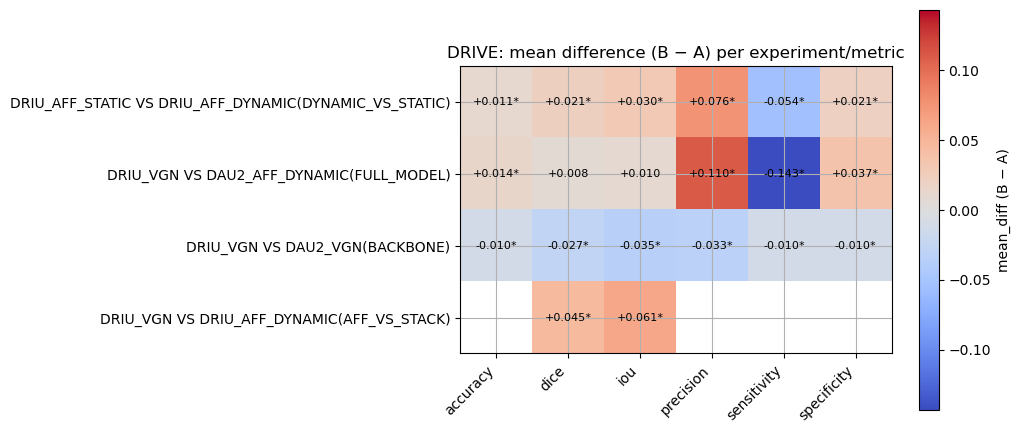

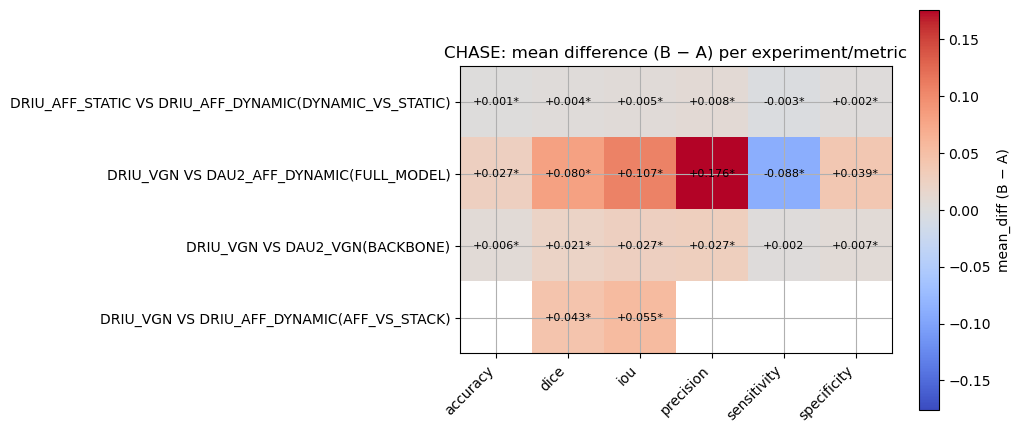

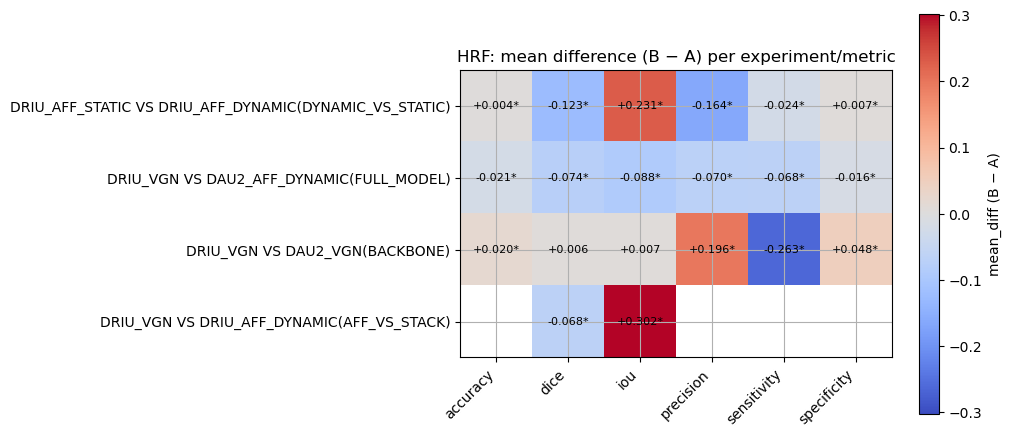

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_diff_heatmap(boot_df, dataset, vmin=None, vmax=None):
    sub = boot_df[boot_df["dataset"] == dataset].copy()
    if sub.empty:
        print(f"No rows for dataset={dataset}")
        return
    
    metrics = sorted(sub["metric"].unique())
    exps    = sorted(sub["experiment"].unique())
    
    mat      = np.full((len(exps), len(metrics)), np.nan)
    sig_mask = np.zeros_like(mat, dtype=bool)
    
    for i, exp in enumerate(exps):
        for j, metric in enumerate(metrics):
            row = sub[(sub["experiment"] == exp) & (sub["metric"] == metric)]
            if row.empty:
                continue
            mat[i, j]      = row["mean_diff"].iloc[0]
            sig_mask[i, j] = bool(row["significant"].iloc[0])
    
    if vmin is None or vmax is None:
        max_abs = np.nanmax(np.abs(mat))
        vmin, vmax = -max_abs, +max_abs

    fig, ax = plt.subplots(figsize=(10, 4 + 0.3*len(exps)))
    im = ax.imshow(mat, cmap="coolwarm", vmin=vmin, vmax=vmax)
    
    # annotate with numbers and stars for significance
    for i in range(len(exps)):
        for j in range(len(metrics)):
            val = mat[i, j]
            if np.isnan(val):
                continue
            txt = f"{val:+.3f}"
            if sig_mask[i, j]:
                txt += "*"
            ax.text(j, i, txt, ha="center", va="center", fontsize=8)
    
    ax.set_xticks(np.arange(len(metrics)))
    ax.set_xticklabels(metrics, rotation=45, ha="right")
    ax.set_yticks(np.arange(len(exps)))
    ax.set_yticklabels(exps)
    ax.set_title(f"{dataset}: mean difference (B − A) per experiment/metric")
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("mean_diff (B − A)")
    
    plt.tight_layout()
    plt.show()

# Example
for ds in boot_df["dataset"].unique():
    plot_mean_diff_heatmap(boot_df, ds)


C:\Users\rog\AppData\Local\Temp\ipykernel_4008\1043692831.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("bwr", 3)  # blue, white, red


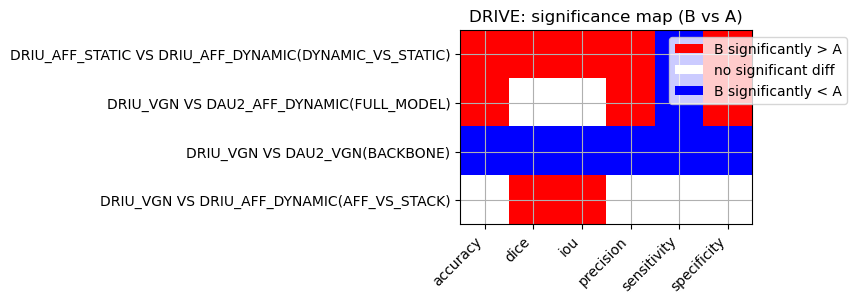

C:\Users\rog\AppData\Local\Temp\ipykernel_4008\1043692831.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("bwr", 3)  # blue, white, red


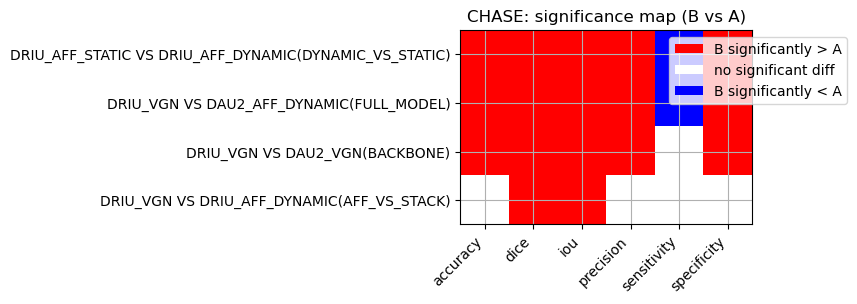

C:\Users\rog\AppData\Local\Temp\ipykernel_4008\1043692831.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("bwr", 3)  # blue, white, red


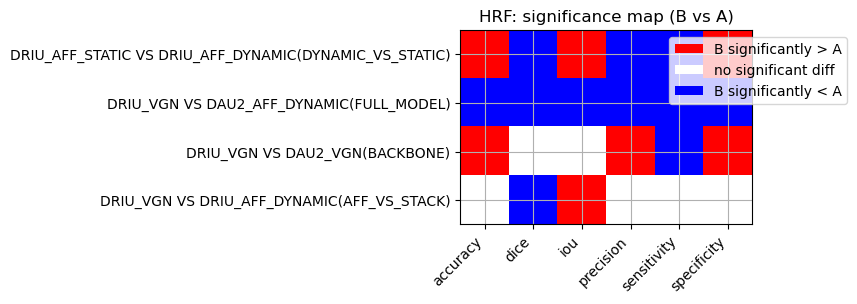

In [28]:
def plot_significance_map(boot_df, dataset):
    sub = boot_df[boot_df["dataset"] == dataset].copy()
    if sub.empty:
        print(f"No rows for dataset={dataset}")
        return
    
    metrics = sorted(sub["metric"].unique())
    exps    = sorted(sub["experiment"].unique())
    
    mat = np.zeros((len(exps), len(metrics)), dtype=int)  # -1 worse, 0 ns, +1 better
    
    for i, exp in enumerate(exps):
        for j, metric in enumerate(metrics):
            row = sub[(sub["experiment"] == exp) & (sub["metric"] == metric)]
            if row.empty:
                continue
            ci_low  = row["ci_low"].iloc[0]
            ci_high = row["ci_high"].iloc[0]
            if ci_low > 0:
                mat[i, j] = +1  # B > A
            elif ci_high < 0:
                mat[i, j] = -1  # B < A
            else:
                mat[i, j] = 0   # ns
    
    cmap = plt.cm.get_cmap("bwr", 3)  # blue, white, red
    
    fig, ax = plt.subplots(figsize=(8, 3 + 0.3*len(exps)))
    im = ax.imshow(mat, cmap=cmap, vmin=-1, vmax=1)
    
    ax.set_xticks(np.arange(len(metrics)))
    ax.set_xticklabels(metrics, rotation=45, ha="right")
    ax.set_yticks(np.arange(len(exps)))
    ax.set_yticklabels(exps)
    ax.set_title(f"{dataset}: significance map (B vs A)")
    
    # manual legend
    from matplotlib.patches import Patch
    legend_elems = [
        Patch(facecolor=cmap(2), label="B significantly > A"),
        Patch(facecolor=cmap(1), label="no significant diff"),
        Patch(facecolor=cmap(0), label="B significantly < A"),
    ]
    ax.legend(handles=legend_elems, loc="upper right", bbox_to_anchor=(1.35, 1.0))
    
    plt.tight_layout()
    plt.show()

for ds in boot_df["dataset"].unique():
    plot_significance_map(boot_df, ds)


C:\Users\rog\AppData\Local\Temp\ipykernel_4008\976653721.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(iou_data, labels=models, showfliers=False)


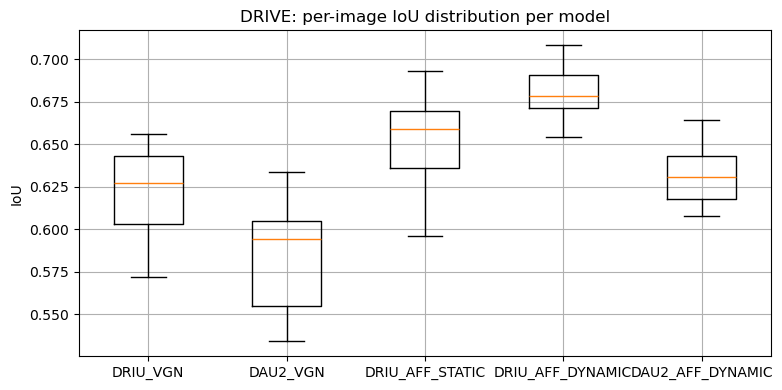

C:\Users\rog\AppData\Local\Temp\ipykernel_4008\976653721.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(iou_data, labels=models, showfliers=False)


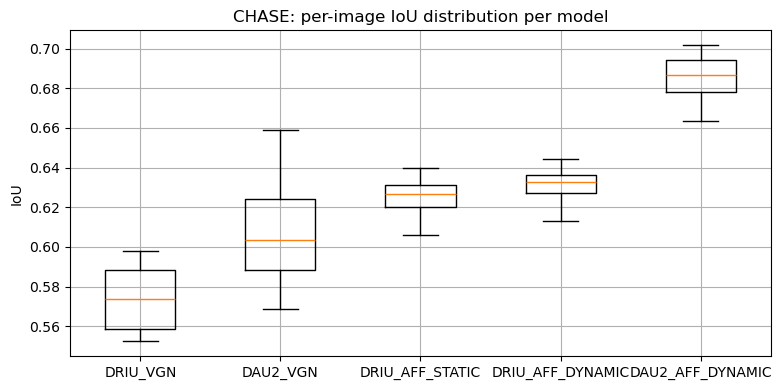

C:\Users\rog\AppData\Local\Temp\ipykernel_4008\976653721.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(iou_data, labels=models, showfliers=False)


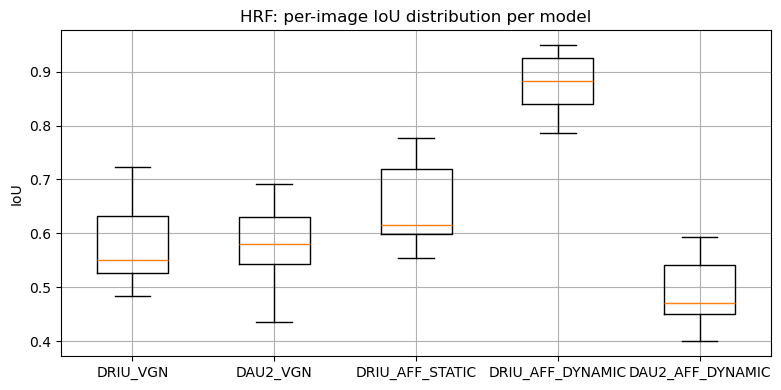

In [30]:
def plot_iou_boxplots(data, dataset):
    sub = data[dataset]
    models = list(sub.keys())
    
    iou_data = [sub[m]["iou"].values for m in models]
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.boxplot(iou_data, labels=models, showfliers=False)
    ax.set_title(f"{dataset}: per-image IoU distribution per model")
    ax.set_ylabel("IoU")
    plt.tight_layout()
    plt.show()

for ds in DATASET_FILES.keys():
    plot_iou_boxplots(data, ds)



=== DRIU_VGN VS DAU2_VGN(BACKBONE) ===
  CHASE: DRIU_VGN -> DAU2_VGN, metric=accuracy


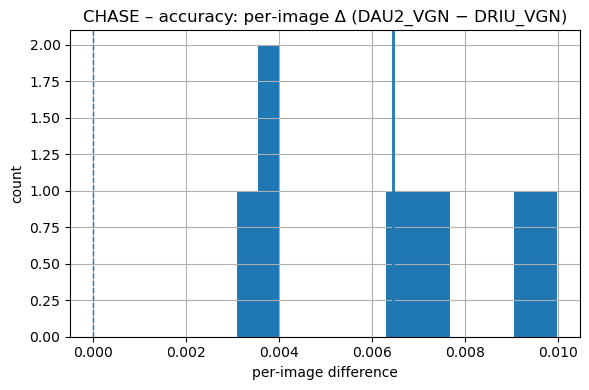

  CHASE: DRIU_VGN -> DAU2_VGN, metric=specificity


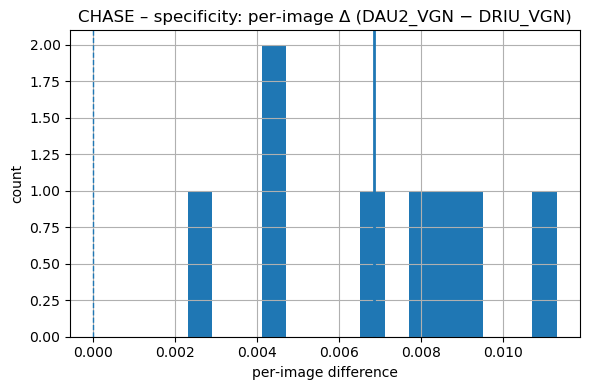

  CHASE: DRIU_VGN -> DAU2_VGN, metric=sensitivity


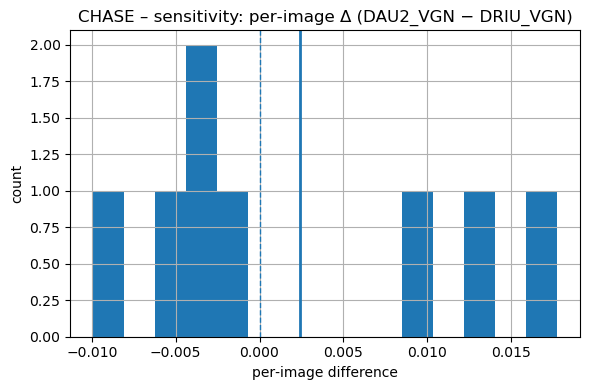

  CHASE: DRIU_VGN -> DAU2_VGN, metric=precision


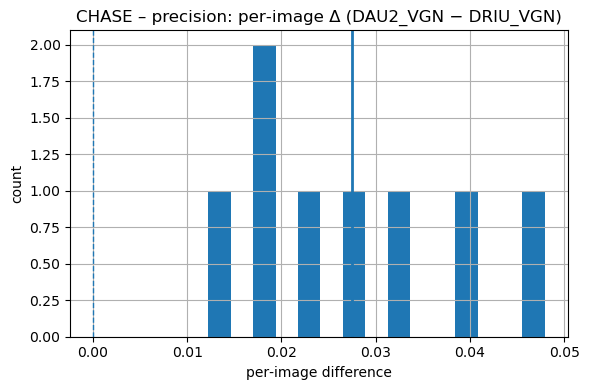

  CHASE: DRIU_VGN -> DAU2_VGN, metric=dice


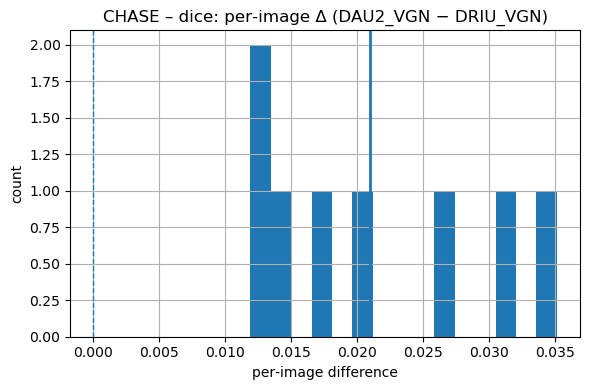

  CHASE: DRIU_VGN -> DAU2_VGN, metric=iou


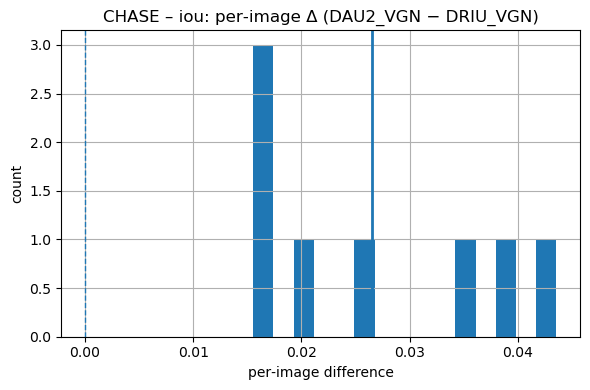

  DRIVE: DRIU_VGN -> DAU2_VGN, metric=accuracy


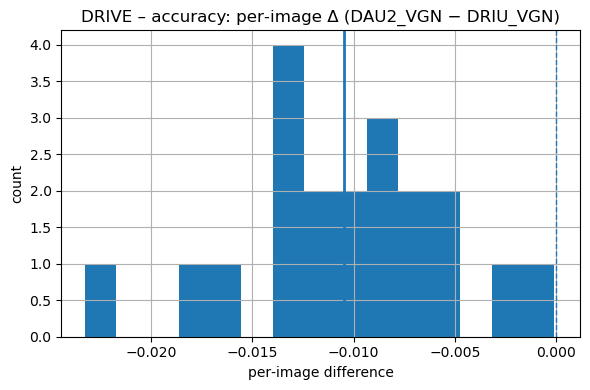

  DRIVE: DRIU_VGN -> DAU2_VGN, metric=specificity


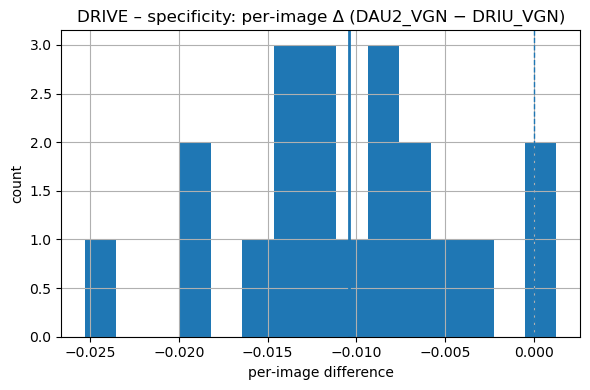

  DRIVE: DRIU_VGN -> DAU2_VGN, metric=sensitivity


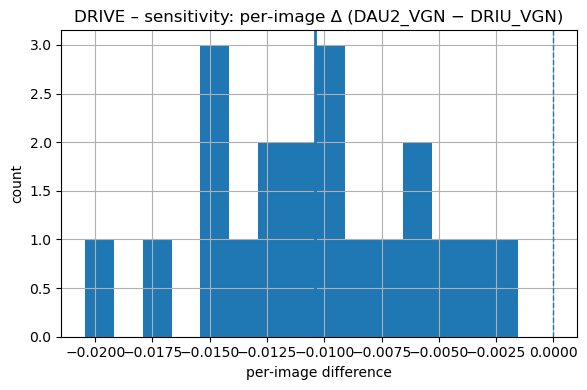

  DRIVE: DRIU_VGN -> DAU2_VGN, metric=precision


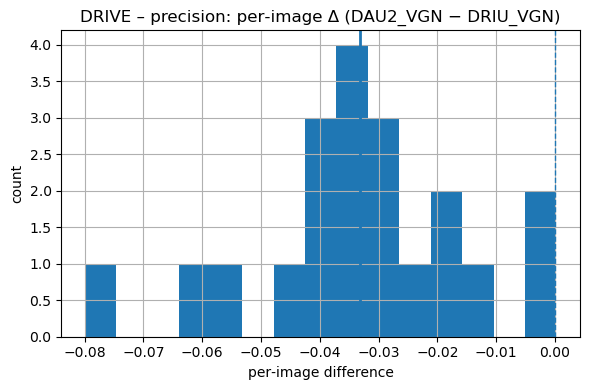

  DRIVE: DRIU_VGN -> DAU2_VGN, metric=dice


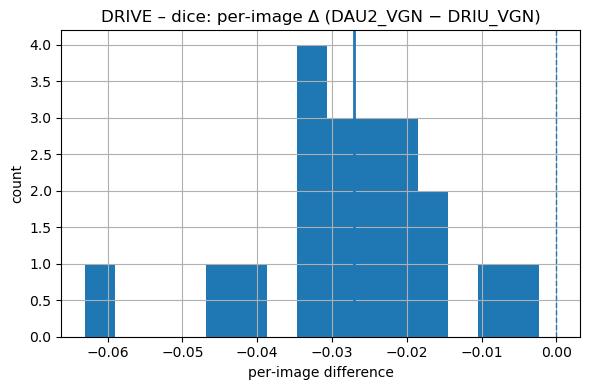

  DRIVE: DRIU_VGN -> DAU2_VGN, metric=iou


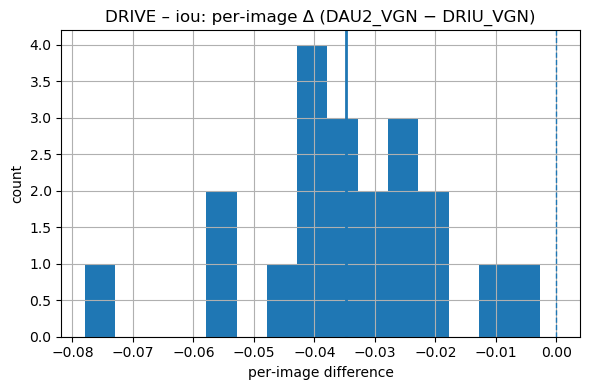

  HRF: DRIU_VGN -> DAU2_VGN, metric=accuracy


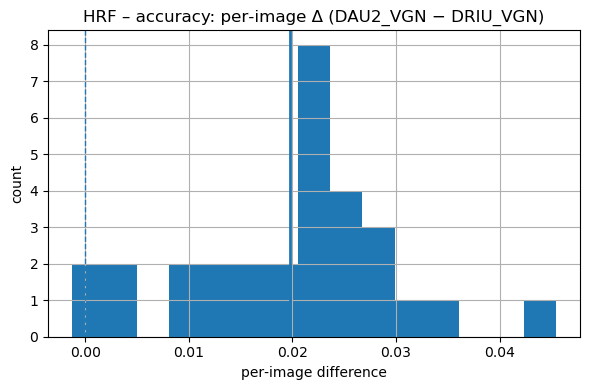

  HRF: DRIU_VGN -> DAU2_VGN, metric=specificity


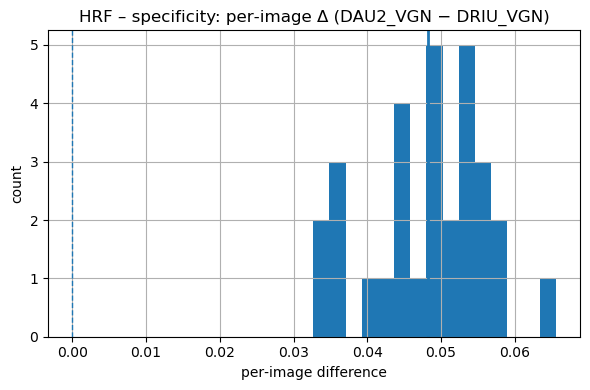

  HRF: DRIU_VGN -> DAU2_VGN, metric=sensitivity


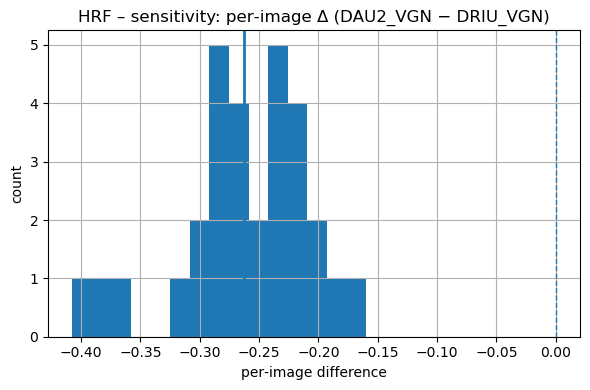

  HRF: DRIU_VGN -> DAU2_VGN, metric=precision


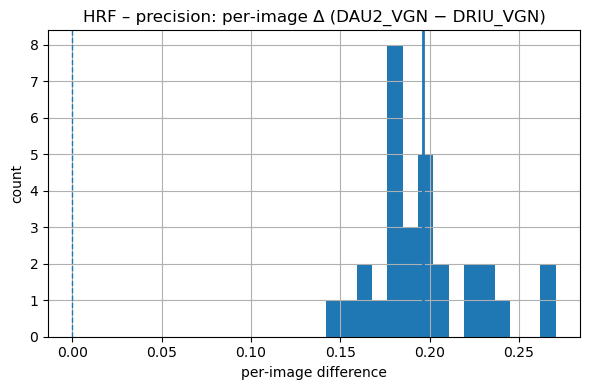

  HRF: DRIU_VGN -> DAU2_VGN, metric=dice


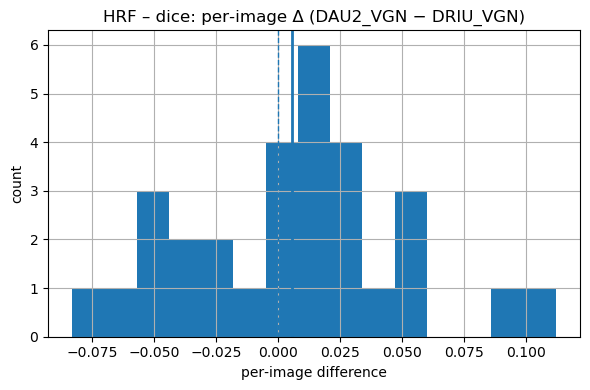

  HRF: DRIU_VGN -> DAU2_VGN, metric=iou


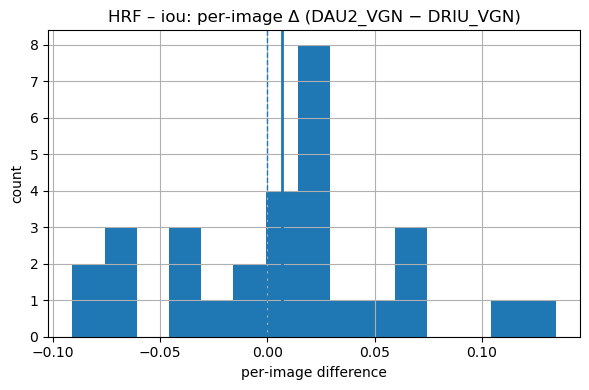


=== DRIU_VGN VS DRIU_AFF_DYNAMIC(AFF_VS_STACK) ===
  CHASE: DRIU_VGN -> DRIU_AFF_DYNAMIC, metric=dice


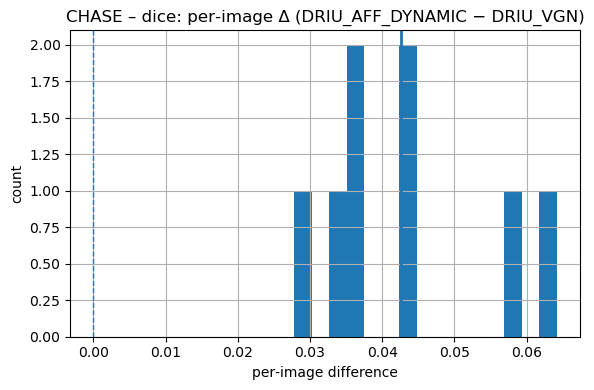

  CHASE: DRIU_VGN -> DRIU_AFF_DYNAMIC, metric=iou


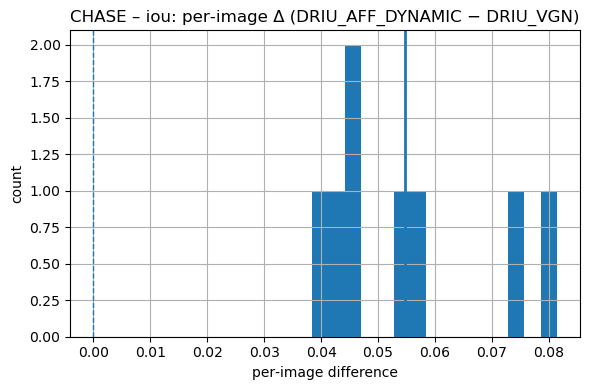

  DRIVE: DRIU_VGN -> DRIU_AFF_DYNAMIC, metric=dice


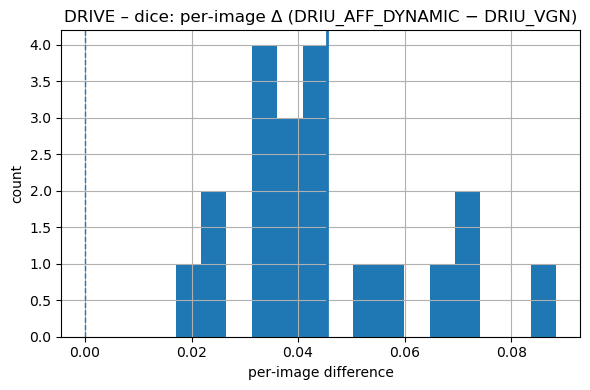

  DRIVE: DRIU_VGN -> DRIU_AFF_DYNAMIC, metric=iou


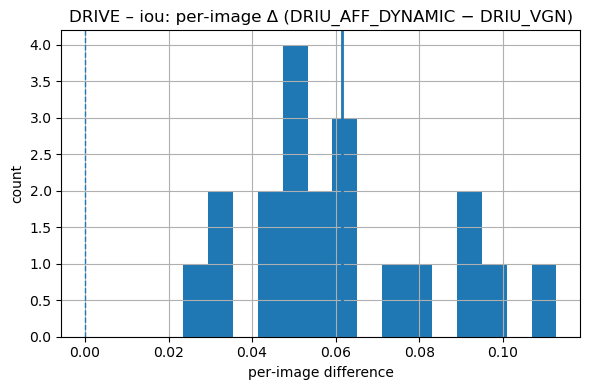

  HRF: DRIU_VGN -> DRIU_AFF_DYNAMIC, metric=dice


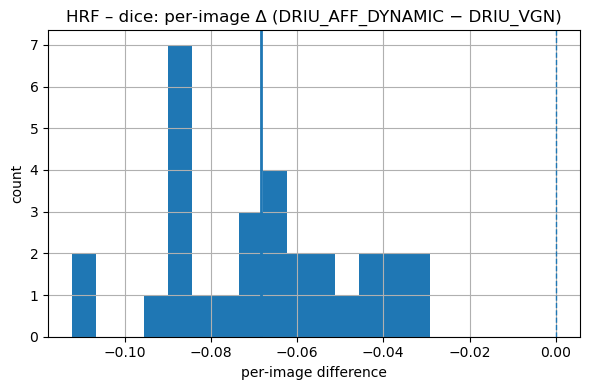

  HRF: DRIU_VGN -> DRIU_AFF_DYNAMIC, metric=iou


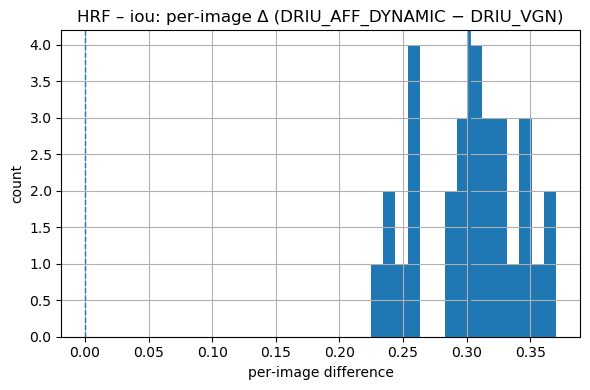


=== DRIU_AFF_STATIC VS DRIU_AFF_DYNAMIC(DYNAMIC_VS_STATIC) ===
  CHASE: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=accuracy


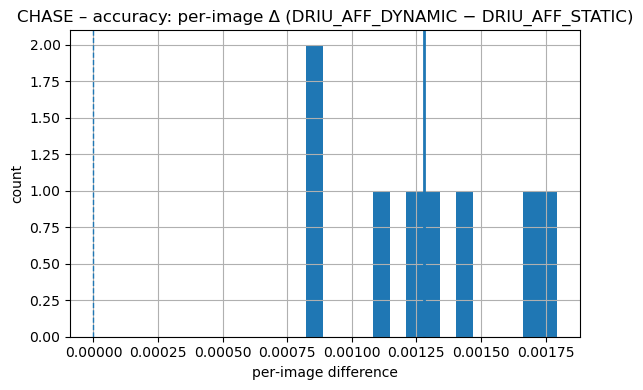

  CHASE: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=specificity


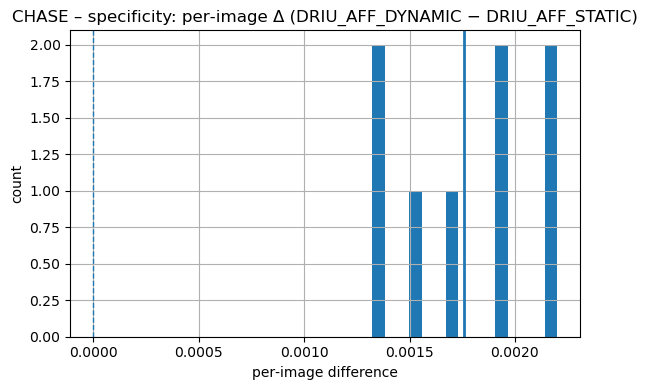

  CHASE: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=sensitivity


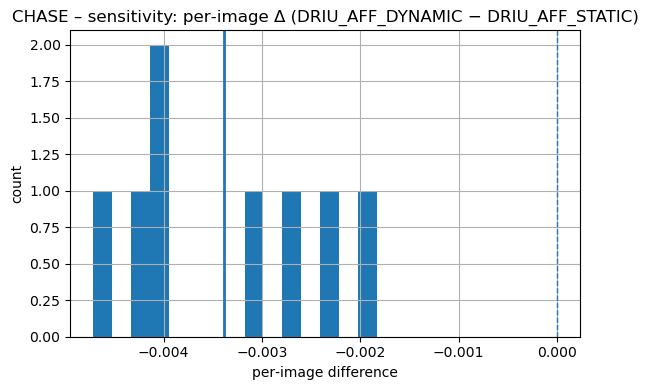

  CHASE: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=precision


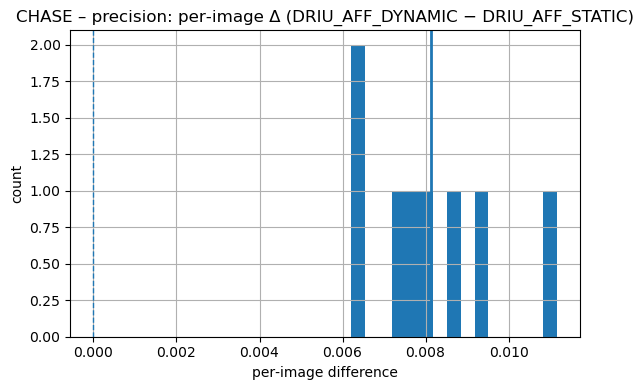

  CHASE: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=dice


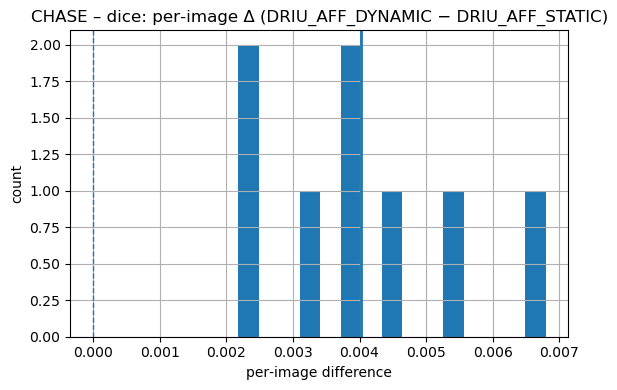

  CHASE: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=iou


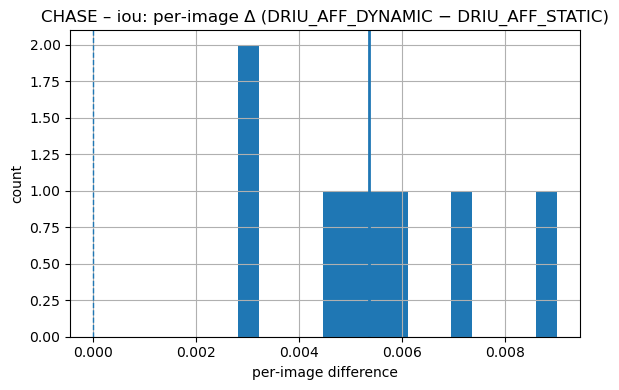

  DRIVE: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=accuracy


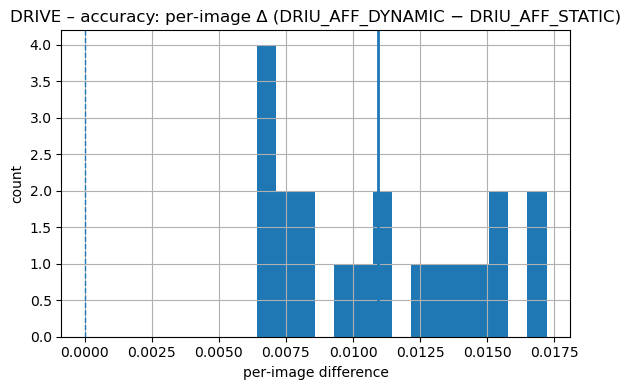

  DRIVE: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=specificity


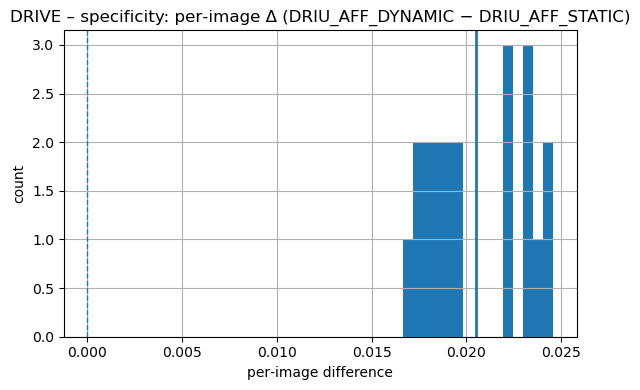

  DRIVE: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=sensitivity


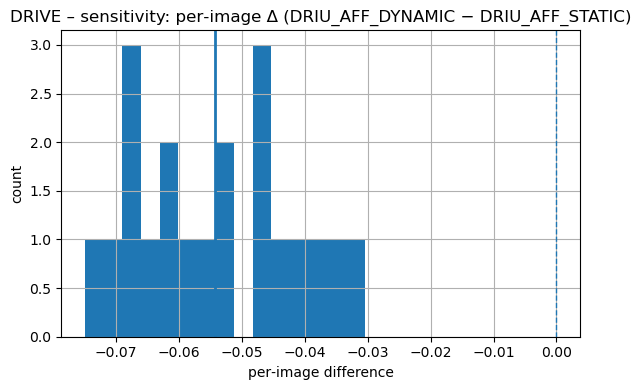

  DRIVE: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=precision


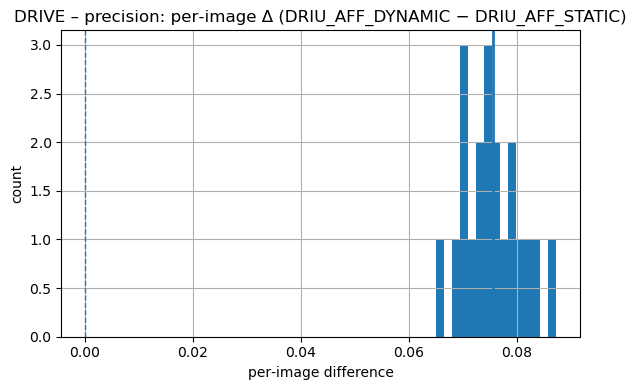

  DRIVE: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=dice


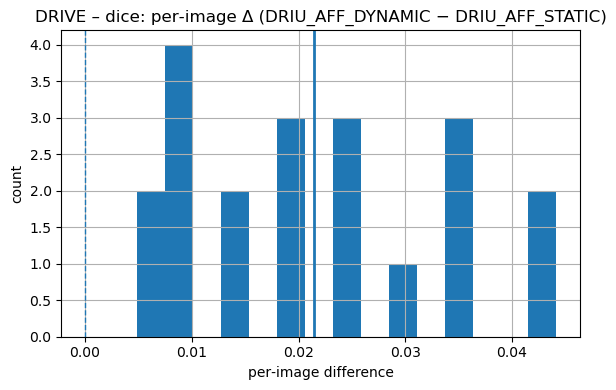

  DRIVE: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=iou


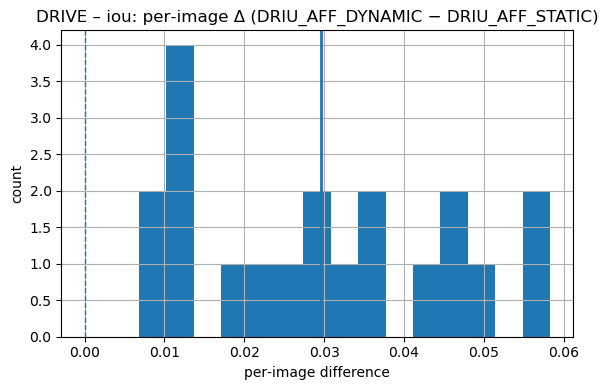

  HRF: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=accuracy


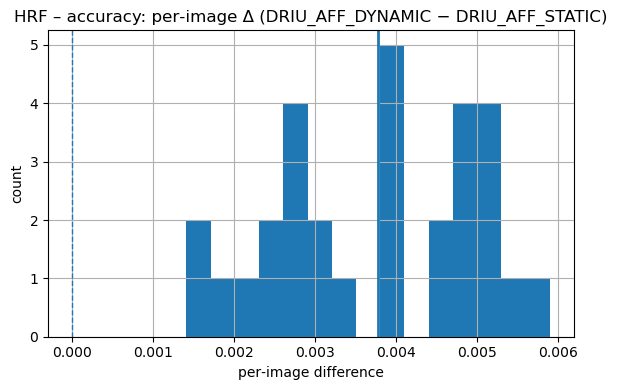

  HRF: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=specificity


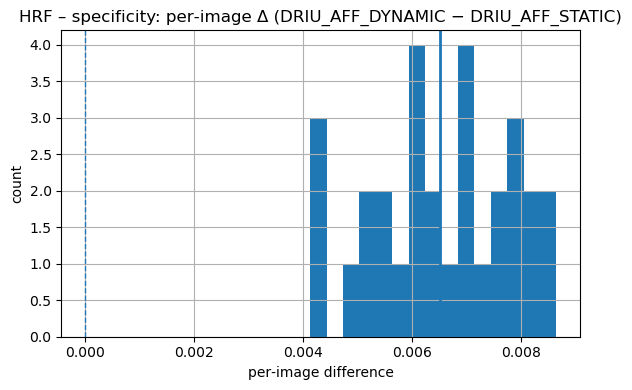

  HRF: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=sensitivity


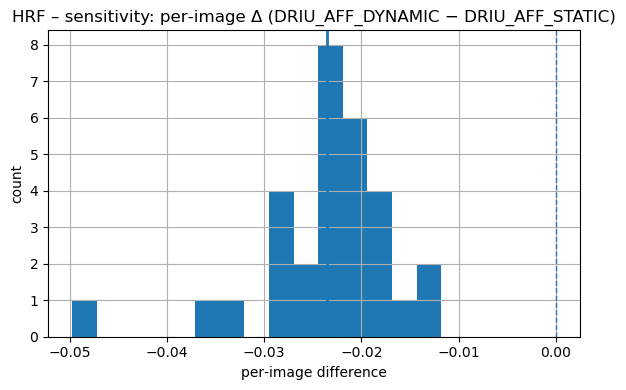

  HRF: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=precision


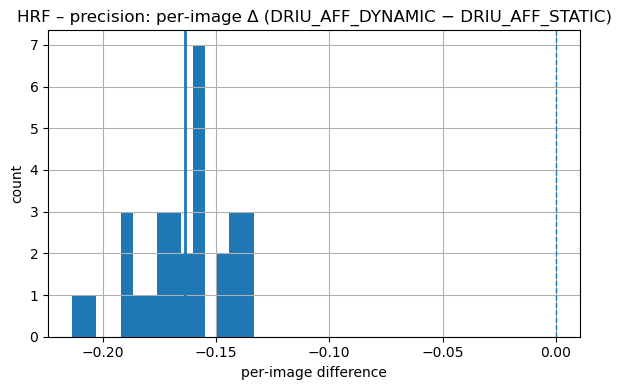

  HRF: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=dice


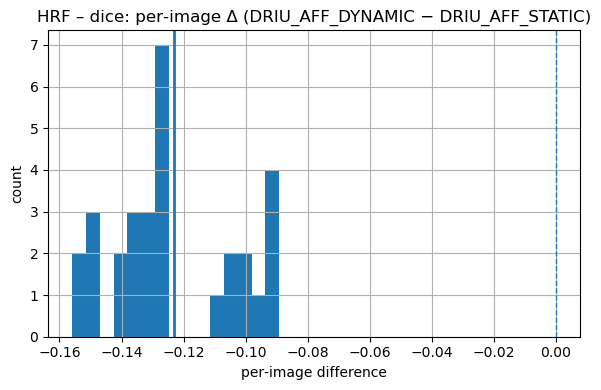

  HRF: DRIU_AFF_STATIC -> DRIU_AFF_DYNAMIC, metric=iou


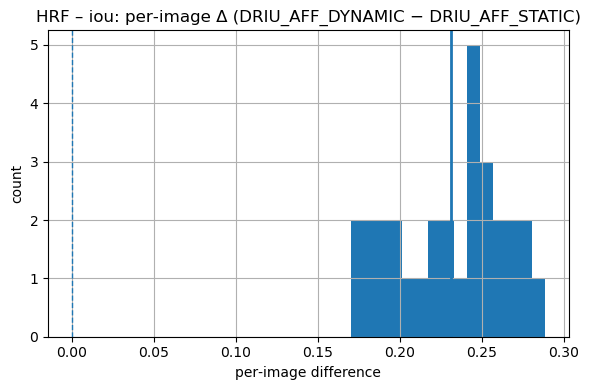


=== DRIU_VGN VS DAU2_AFF_DYNAMIC(FULL_MODEL) ===
  CHASE: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=accuracy


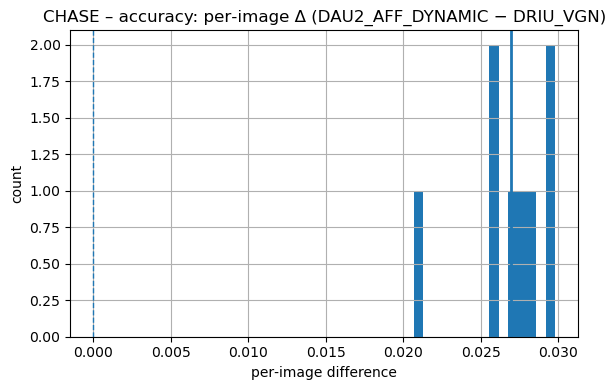

  CHASE: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=specificity


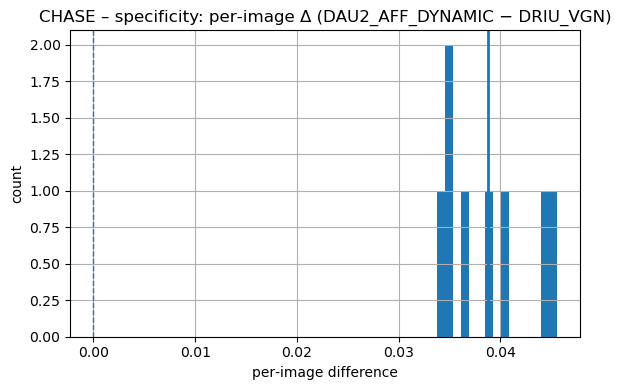

  CHASE: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=sensitivity


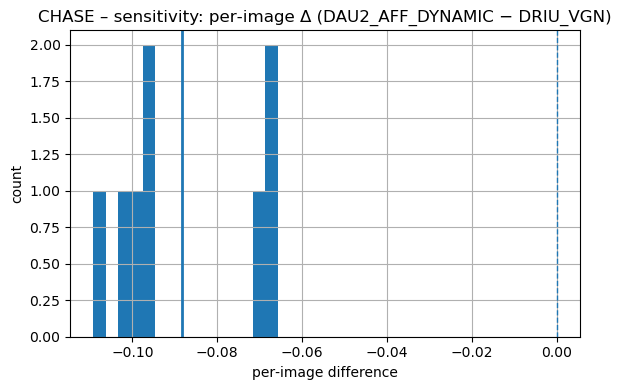

  CHASE: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=precision


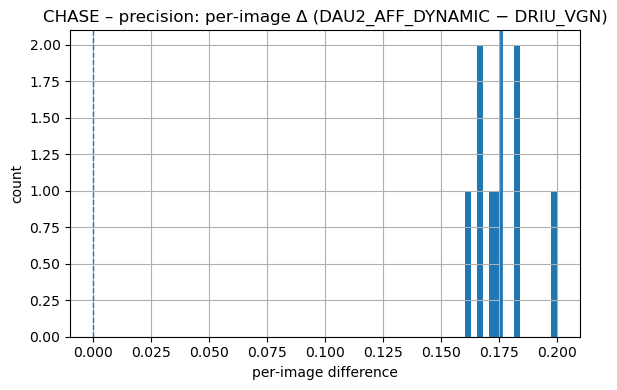

  CHASE: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=dice


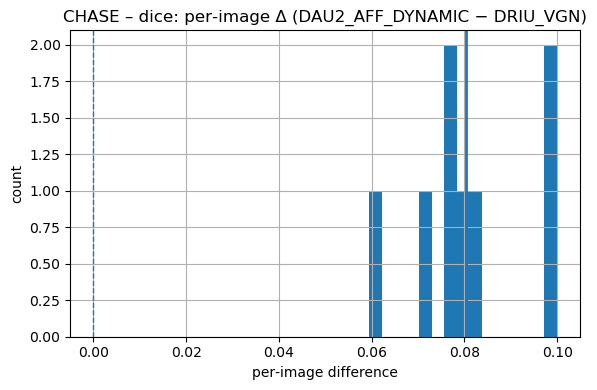

  CHASE: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=iou


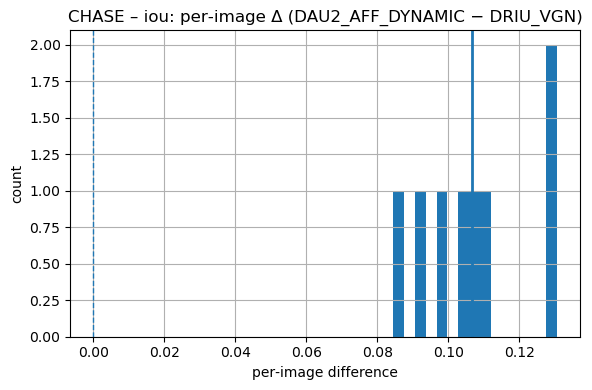

  DRIVE: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=accuracy


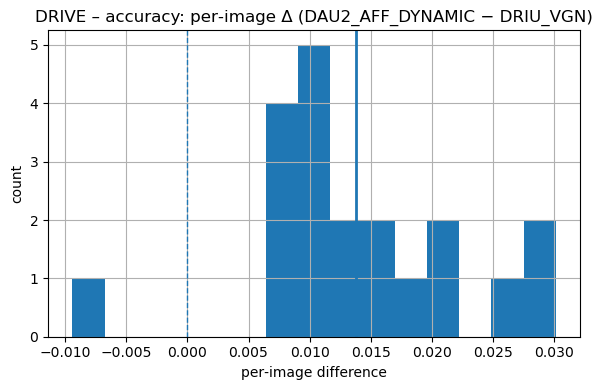

  DRIVE: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=specificity


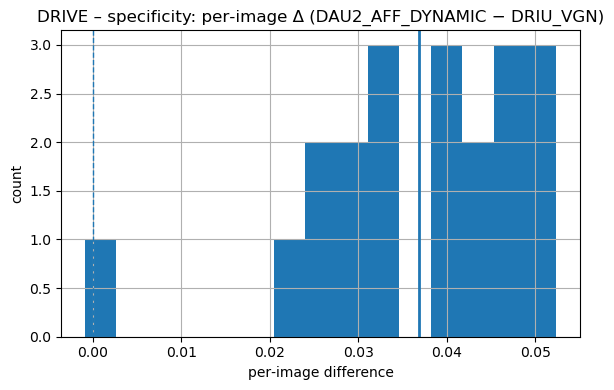

  DRIVE: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=sensitivity


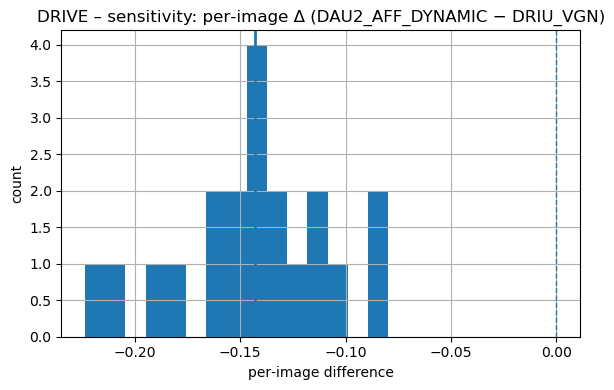

  DRIVE: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=precision


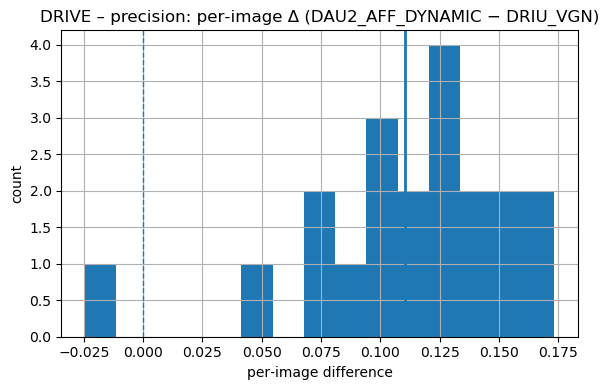

  DRIVE: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=dice


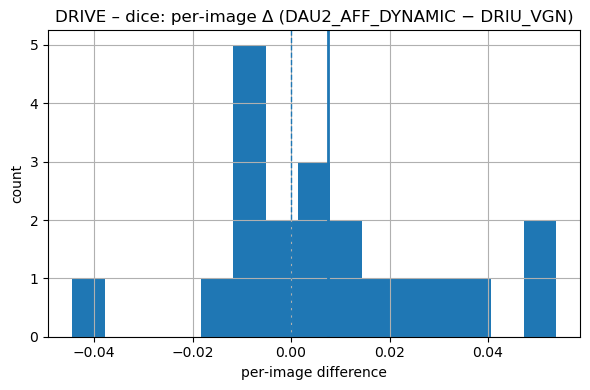

  DRIVE: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=iou


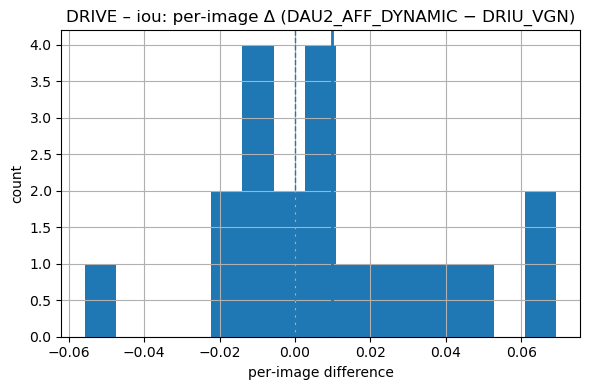

  HRF: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=accuracy


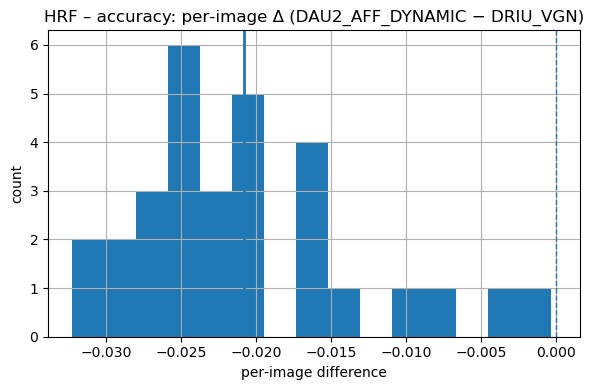

  HRF: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=specificity


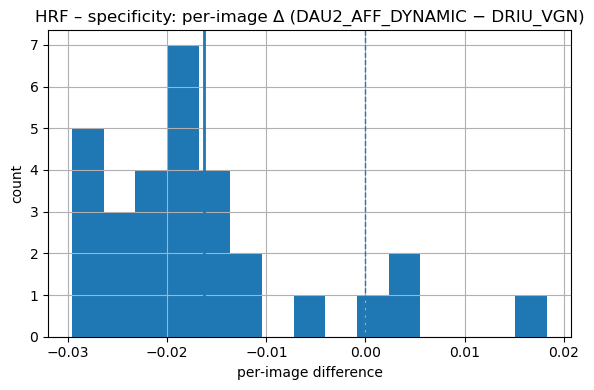

  HRF: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=sensitivity


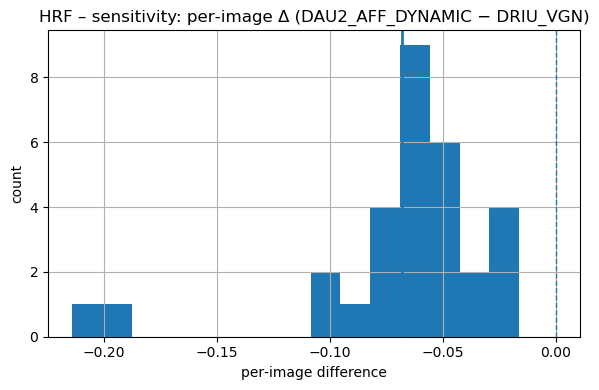

  HRF: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=precision


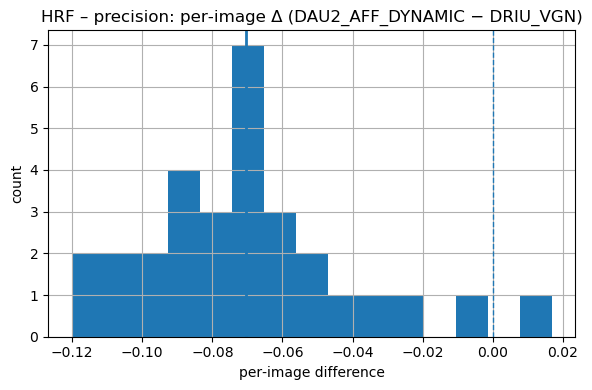

  HRF: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=dice


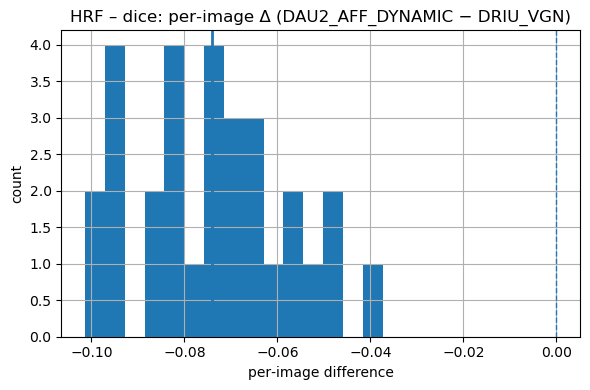

  HRF: DRIU_VGN -> DAU2_AFF_DYNAMIC, metric=iou


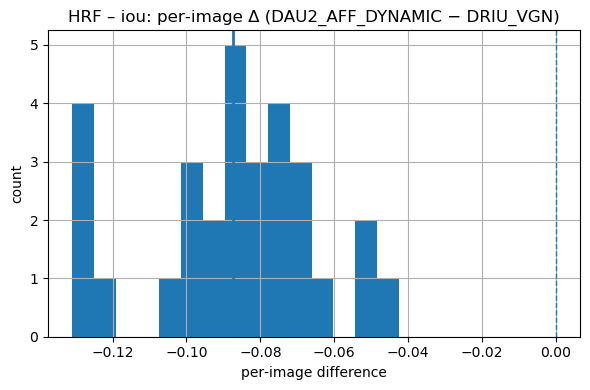

In [32]:
def plot_per_image_delta_hist(data, dataset, model_a, model_b, metric, bins=15):
    df_a = data[dataset][model_a]
    df_b = data[dataset][model_b]

    merged = pd.merge(
        df_a[["image_id", metric]],
        df_b[["image_id", metric]],
        on="image_id",
        suffixes=("_A", "_B"),
        validate="one_to_one",
    )

    diffs = merged[f"{metric}_B"] - merged[f"{metric}_A"]

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axvline(0.0, linestyle="--", linewidth=1)          # null line
    ax.hist(diffs, bins=bins)                             # distribution of per‑image Δ

    mean_delta = diffs.mean()
    ax.axvline(mean_delta, linestyle="-", linewidth=2)    # mean Δ line

    ax.set_title(
        f"{dataset} – {metric}: per‑image Δ ({model_b} − {model_a})"
    )
    ax.set_xlabel("per‑image difference")
    ax.set_ylabel("count")

    plt.tight_layout()
    plt.show()


def plot_all_deltas_from_bootdf(data, boot_df, bins=15):
    """
    For every (experiment, dataset, model_A, model_B, metric) present in boot_df,
    plot the per‑image delta histogram: metric_B − metric_A.
    WARNING: this can easily be 50+ figures.
    """
    # iterate by experiment to keep things organized
    for exp in boot_df["experiment"].unique():
        sub_exp = boot_df[boot_df["experiment"] == exp]

        print(f"\n=== {exp} ===")
        for (ds, ma, mb), group in sub_exp.groupby(["dataset", "model_A", "model_B"]):
            metrics = group["metric"].unique()
            for metric in metrics:
                print(f"  {ds}: {ma} -> {mb}, metric={metric}")
                plot_per_image_delta_hist(
                    data, ds, ma, mb, metric, bins=bins
                )

# Call once to blast out ALL histograms that correspond to your bootstrap table
plot_all_deltas_from_bootdf(data, boot_df, bins=15)
